# Import librairies

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
!pip install Pillow
!pip install scipy

In [4]:
!wget https://parismatch.be/app/uploads/2018/04/Macaca_nigra_self-portrait_large-e1524567086123-1100x715.jpg
!mkdir image/
!mkdir image/macaque
!mv Macaca_nigra_self-portrait_large-e1524567086123-1100x715.jpg image/macaque/

--2020-03-11 14:55:22--  https://parismatch.be/app/uploads/2018/04/Macaca_nigra_self-portrait_large-e1524567086123-1100x715.jpg
Resolving parismatch.be (parismatch.be)... 137.74.175.105
Connecting to parismatch.be (parismatch.be)|137.74.175.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144364 (141K) [image/jpeg]
Saving to: ‘Macaca_nigra_self-portrait_large-e1524567086123-1100x715.jpg’

Macaca_nigra_self-p 100%[===================>] 140.98K   517KB/s    in 0.3s    

2020-03-11 14:55:28 (517 KB/s) - ‘Macaca_nigra_self-portrait_large-e1524567086123-1100x715.jpg’ saved [144364/144364]



In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset


# Define the neural network

In [0]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

# Download the Dataset

In [7]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.Resize(28,28),transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)


Extracting mnist-data/MNIST/raw/train-images-idx3-ubyte.gz to mnist-data/MNIST/raw



Extracting mnist-data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist-data/MNIST/raw



Extracting mnist-data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist-data/MNIST/raw



Extracting mnist-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist-data/MNIST/raw
Processing...
Done!


In [0]:
net = NN(28*28, 1024, 10)

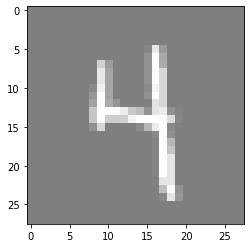

tensor(4)


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()
image = images[0]
label = labels[0]

# show images
imshow(torchvision.utils.make_grid(image))
print(label)
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Pyro

In [10]:
!pip install pyro-ppl

     |████████████████████████████████| 501kB 2.8MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [0]:
log_softmax = nn.LogSoftmax(dim=1)

# Define the model pyro

In [0]:
def model(x_data, y_data):
    #define the prior on the W and bias of the first layer ici normal 0,I pour les 2
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight)) 
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    #define the prior on the W ans bias of the second layer ici normal 0,I pour les 2 
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    #on fait un dictionnaire avec ces 4 distributions
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)


    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    #le resultat du regressor
    lhat = log_softmax(lifted_reg_model(x_data))
    #tirer une observation obs depuis les probas générés par le régresseur sampler 
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

# Define the pyro guide

The guide function help us to initialize a well behavied distribution that later we can optimize to approximate the true posterior

L'objectif du guide est de ressortir une variable normale qui approxime bien la fonction donné par le model

On va faire de l'inférence entre ces deux fonctions grace à la KL divergence

In [0]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors 
    #chaque Wi,j suit une loi normale mui,j sigmai,j mais cette fois avec mui,j et sigmai,j sont
    #tirés aléatoirement depuis une normale 0,1
    fc1w_mu = torch.randn_like(net.fc1.weight) #on dis que le mu W est un vectreur de la bonne taillle
    fc1w_sigma = torch.randn_like(net.fc1.weight) #on dit que le mu sigma est un vecteur de la bonne taille
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu) #on défini le parametre Wmu du premier layer
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma)) #et le sigma
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param) #et on definit la loi priors de W
    # First layer bias distribution priors  
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)

    #on met toutes nos priors dans un dictionnaire
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    

    #lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
   
    
    return lifted_module()

#Optimization


In [0]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO()) #variationnal inference using elbo

In [16]:
#Optimisation loop
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    #data = (images,label) pairs
    #on fait l'inférence petit batch par petit batch à la fois
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Epoch  0  Loss  2092.919202917147
Epoch  1  Loss  375.87160811538695
Epoch  2  Loss  160.18139589565595
Epoch  3  Loss  111.57408302607536
Epoch  4  Loss  97.15609540993373


#Prédictions sans prendre en compte l'uncertainty

In [0]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]  #on tire plusieurs variables 10 fois pour chaque layer
    yhats = [model(x).data for model in sampled_models] #Pour chacun de ces models
    #On calcul l'output et on le store dans yhats
    mean = torch.mean(torch.stack(yhats), 0) #on calcul la moyenne de ses yhats
    return np.argmax(mean.numpy(), axis=1) #et on dit que l'approximation est l'argmax

In [0]:
from tqdm import tqdm

In [19]:
print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in tqdm(enumerate(test_loader)):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0) #128 = la taille du batch
    correct += (np.array(predicted) == np.array(labels)).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

0it [00:00, ?it/s]

Prediction when network is forced to predict


/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
79it [00:46,  1.74it/s]

accuracy: 88 %


#Prédiction en prenant en compte l'uncertainty

In [0]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [0]:
num_samples = 100 #on va créer 100 models
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    #on return la liste des log_softmax sur l'input des 100 models
    return np.asarray(yhats)

In [0]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images) #retournes les differentes log softmax 
    #des predictions faites pas les 100 reseaux
    predicted_for_images = 0 #le nombre de predictions faits
    correct_predictions=0 #le nombre de predictions correctes 

    for i in range(len(labels)): #pour chaque images
    
        if(plot): #Si on veut ploter
            print("Real: ",labels[i].item()) #on affiche le vrai label
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2)) #et on prepare le plot
    
        all_digits_prob = [] #les proba medianes ( parmis nos 100 probas ) que l'image i soit dans
        #chacune des classe d'indice de la liste
    
        highted_something = False #highted si on pense avoir une réponse
    
        for j in range(len(classes)): #pour chacune des classes
        
            highlight=False #on initialise le surlignage a false
        
            histo = [] #on initialise notre histogram
            histo_exp = [] #et notre histogramme_exp
        
            for z in range(y.shape[0]): #pour chacun de nos reseaux
                histo.append(y[z][i][j])#on ajoute dans histo le log softmax de notre réseau que 
                histo_exp.append(np.exp(y[z][i][j])) #et exp de cette valeure dans histo_exp donc juste le softmax
                #ie la proba que l'image i soit dans la classe j d'apres le reseau z
            
            #au final a ce moment la dans histo_exp, on a les probabilités pour chacun de nos reseaux que l'image
            #i soit dans la classe j

            prob = np.percentile(histo_exp, 50) #on chope la probabilité médiane
        
            if(prob>0.2): #si cette probabilité médiane est supérieure à 20 pourcent
                highlight = True #on active le surlignage
        
            all_digits_prob.append(prob) #et on ajoute cette proba à la liste
            
            if(plot): # si on veut ploter
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")")  #on plot l'histogramme
        
            if(highlight): #si on a décidé de surligner
            
                highted_something = True #highted something passe a true
                
                if(plot): #et si on veut ploter

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

        #on a fini de process l'image i 
        if(plot): #donc on fait le plot
            plt.show()
    
        predicted = np.argmax(all_digits_prob) #la valeur prédites est celle qui a la plus grande proba
    
        if(highted_something): #si on a décidé a un moment de highted something
            predicted_for_images+=1 #on ajoute un aux nombres d'images predites
            if(labels[i].item()==predicted): # si la prediction est correcte, on ajoute un au nombre d'immages bien prédites
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot): #on affiche l'image
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Prediction when network can refuse
Real:  2


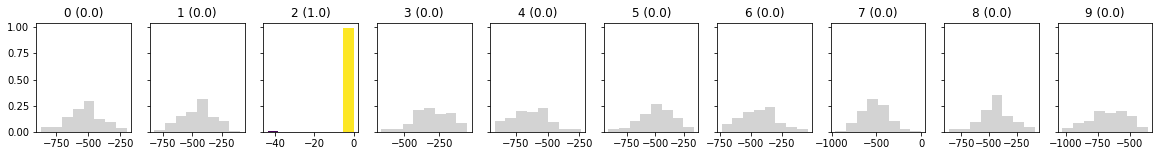

Correct


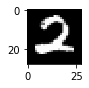

Real:  4


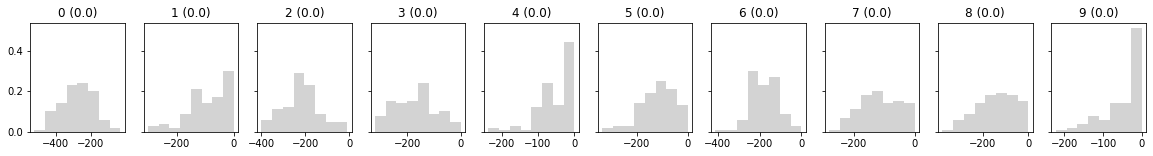

Undecided.


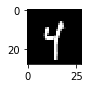

Real:  4


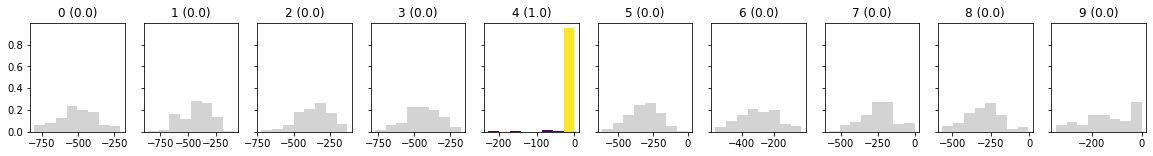

Correct


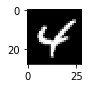

Real:  3


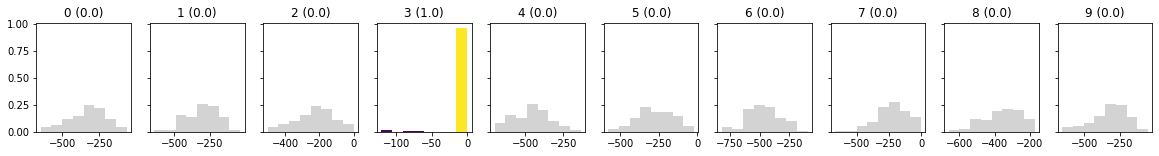

Correct


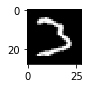

Real:  4


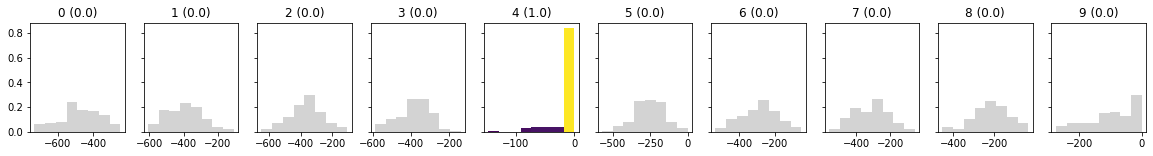

Correct


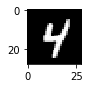

Real:  9


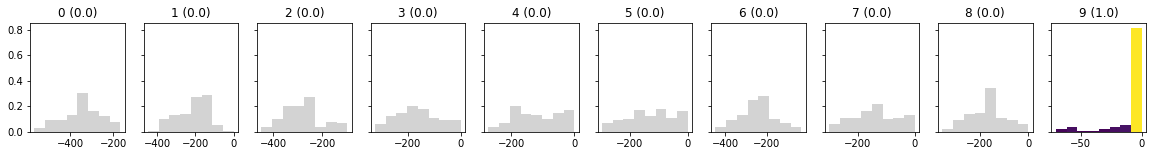

Correct


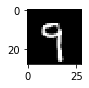

Real:  8


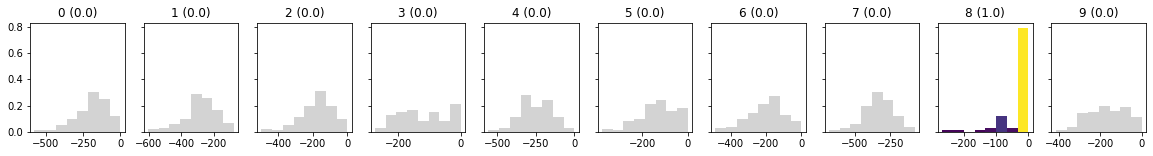

Correct


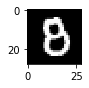

Real:  9


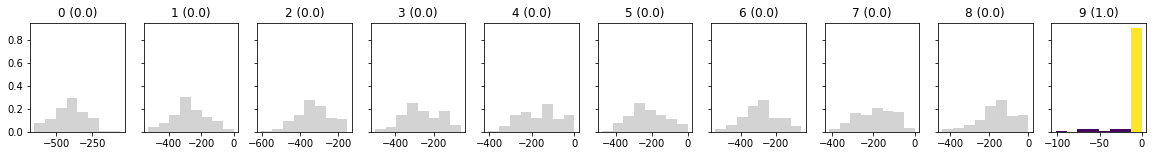

Correct


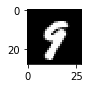

Real:  9


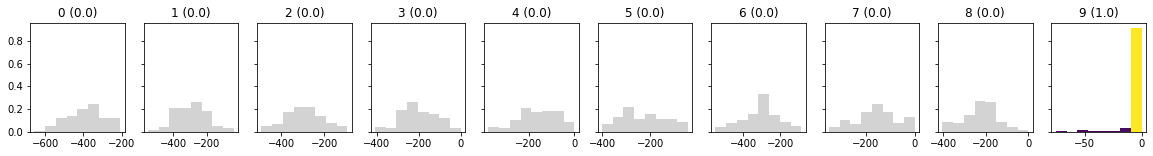

Correct


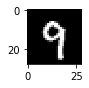

Real:  2


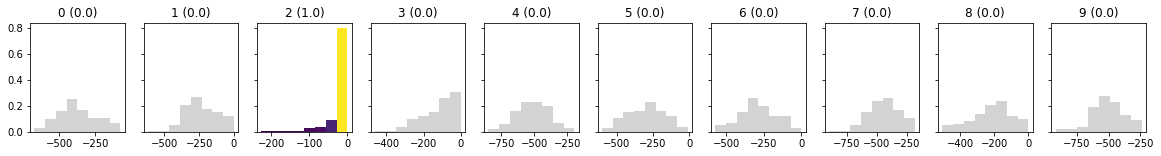

Correct


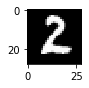

Real:  6


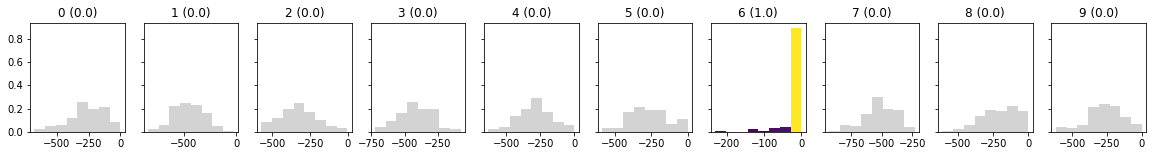

Correct


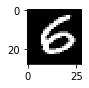

Real:  8


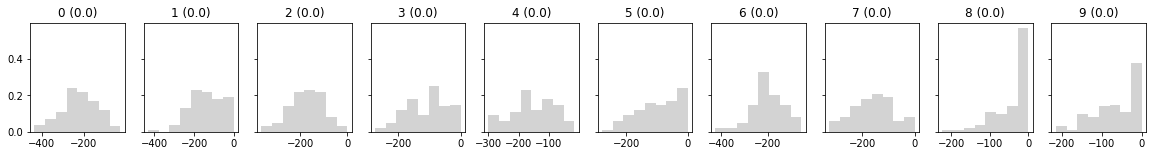

Undecided.


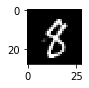

Real:  1


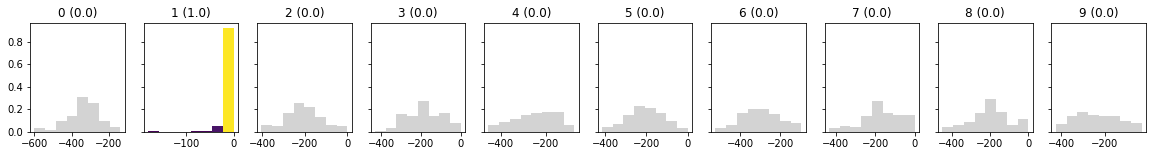

Correct


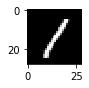

Real:  0


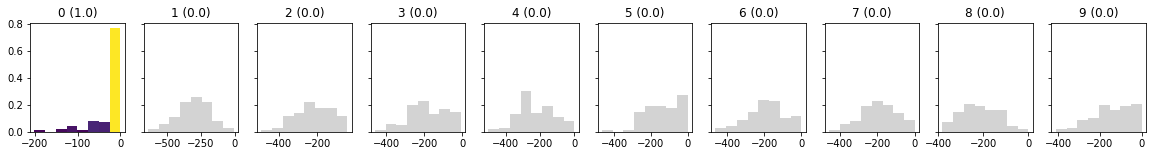

Correct


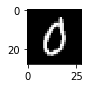

Real:  7


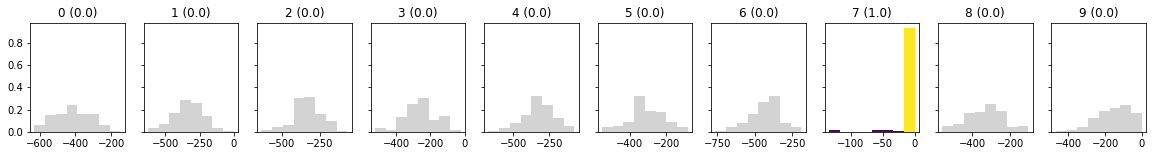

Correct


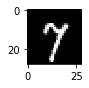

Real:  3


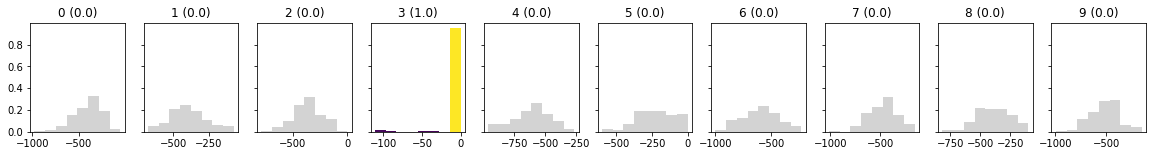

Correct


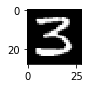

Real:  6


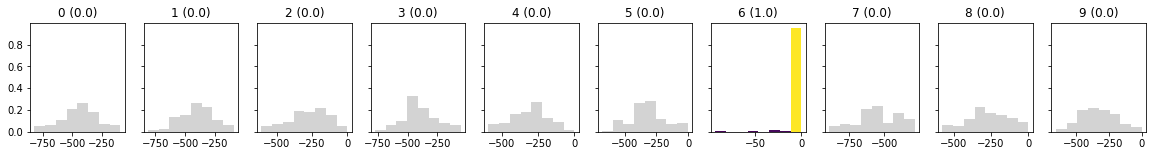

Correct


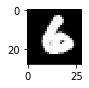

Real:  4


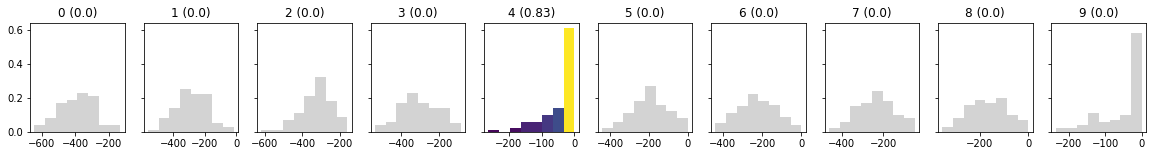

Correct


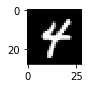

Real:  7


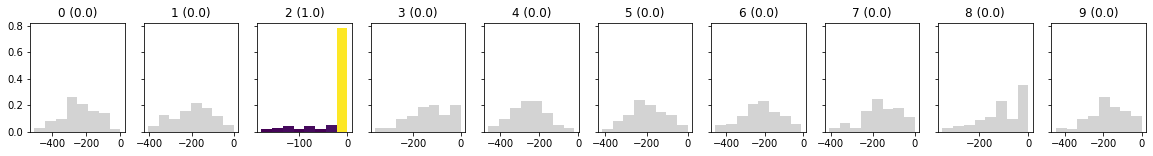

Incorrect :()


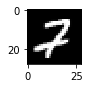

Real:  6


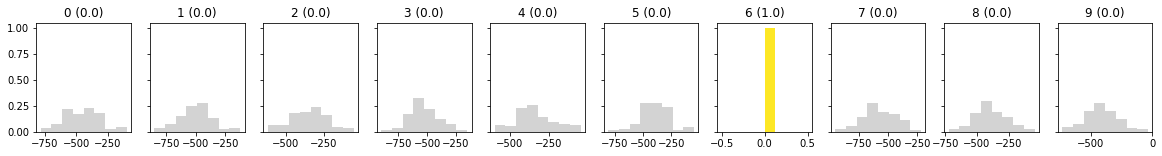

Correct


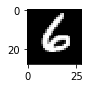

Real:  8


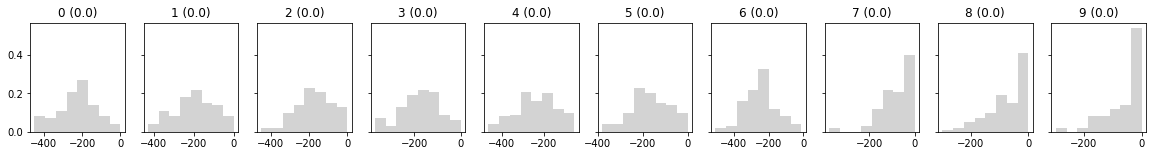

Undecided.


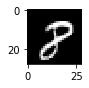

Real:  0


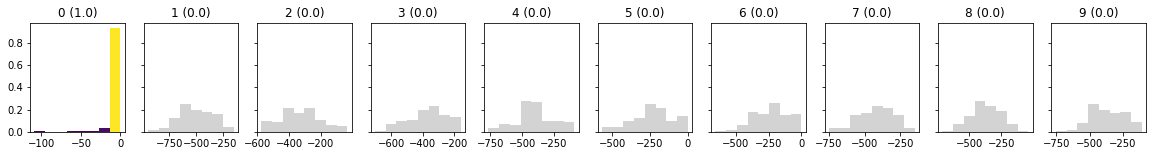

Correct


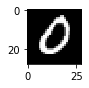

Real:  7


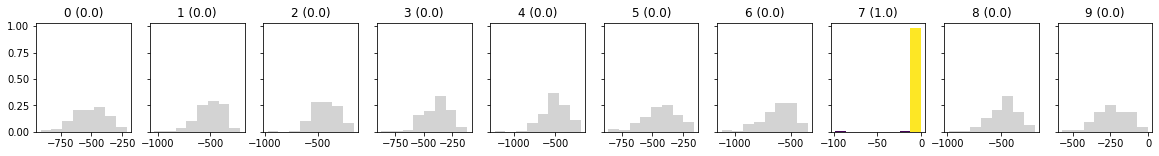

Correct


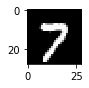

Real:  5


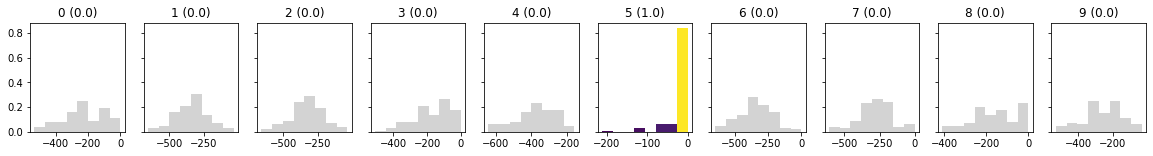

Correct


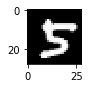

Real:  2


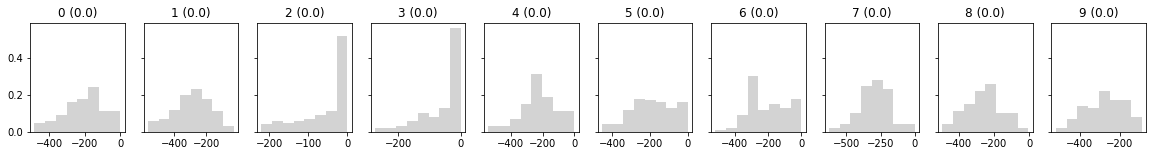

Undecided.


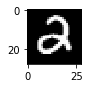

Real:  1


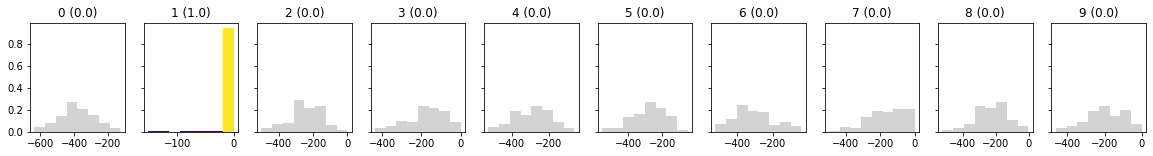

Correct


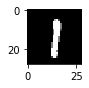

Real:  8


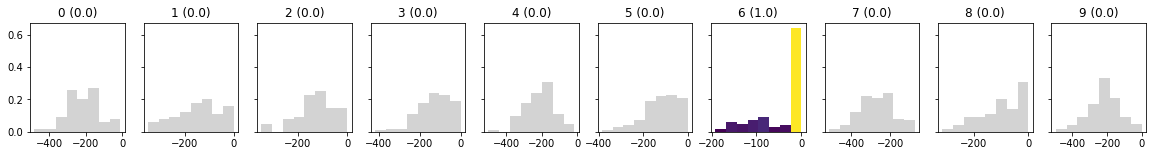

Incorrect :()


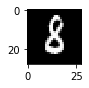

Real:  3


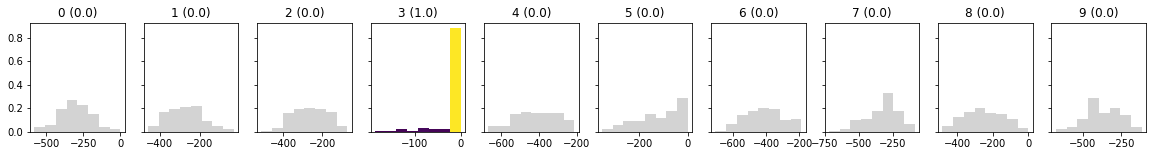

Correct


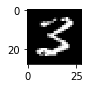

Real:  4


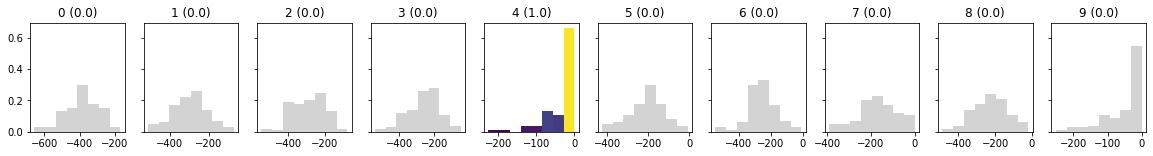

Correct


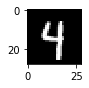

Real:  7


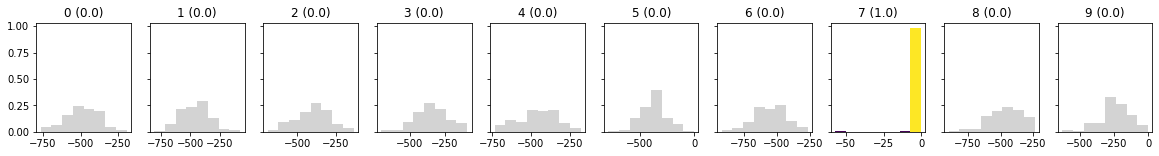

Correct


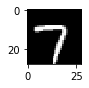

Real:  5


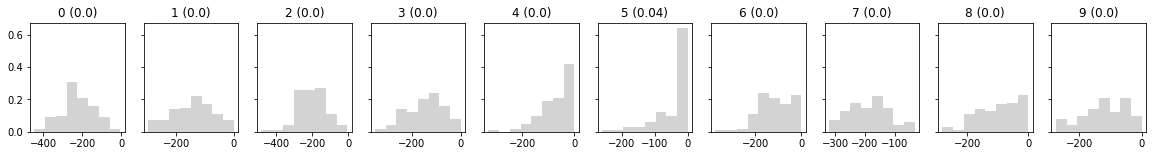

Undecided.


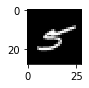

Real:  9


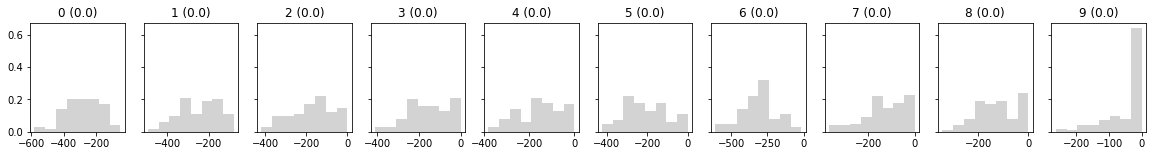

Undecided.


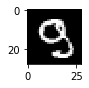

Real:  5


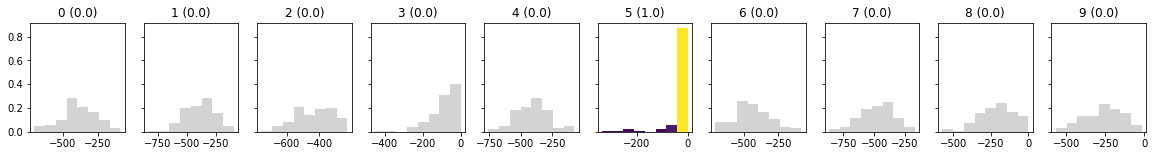

Correct


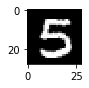

Real:  9


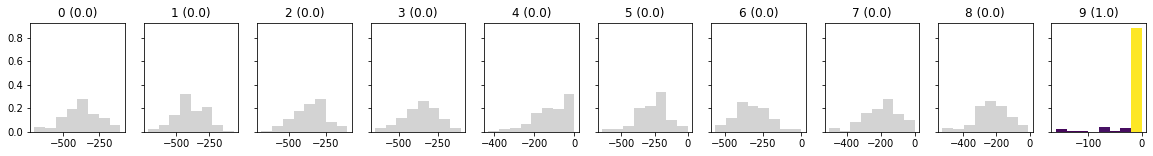

Correct


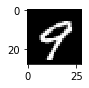

Real:  3


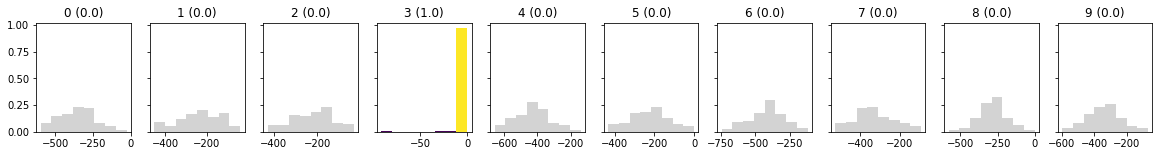

Correct


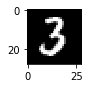

Real:  8


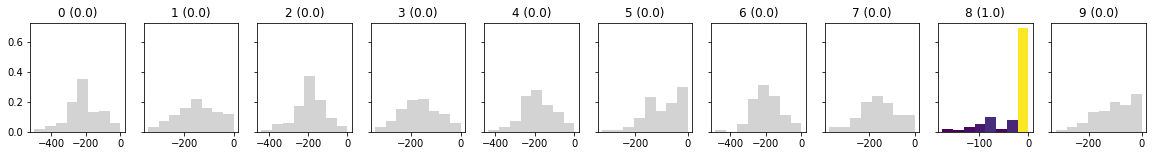

Correct


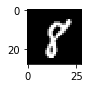

Real:  9


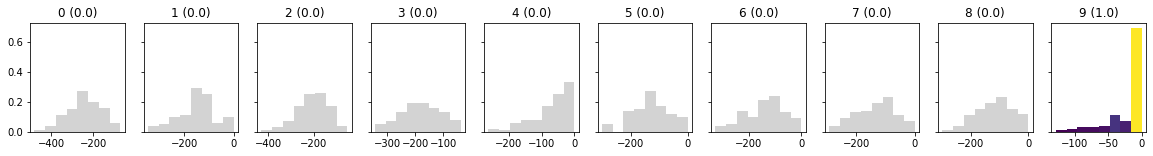

Correct


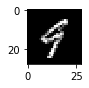

Real:  4


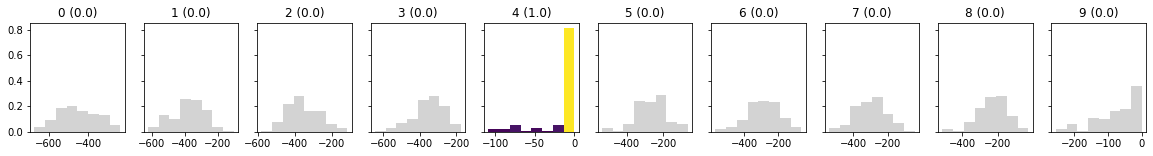

Correct


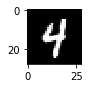

Real:  9


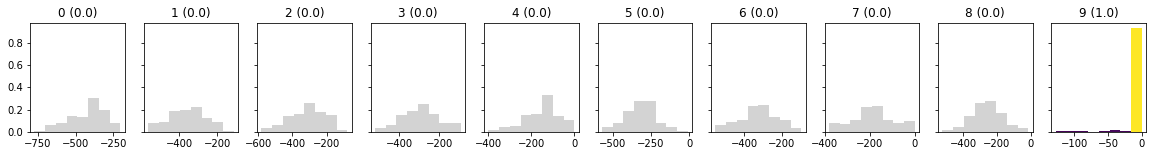

Correct


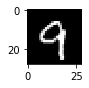

Real:  5


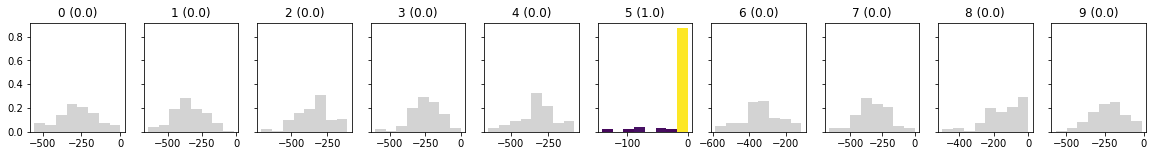

Correct


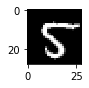

Real:  3


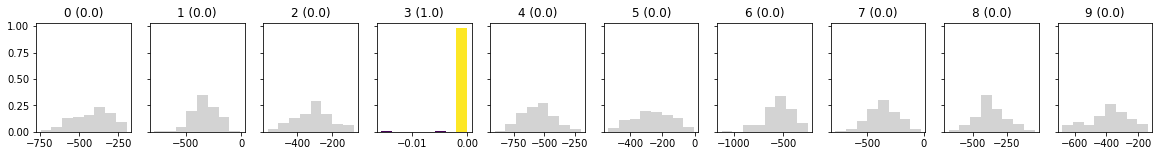

Correct


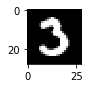

Real:  1


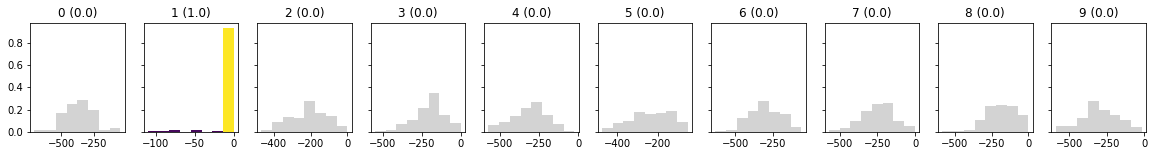

Correct


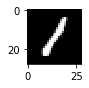

Real:  6


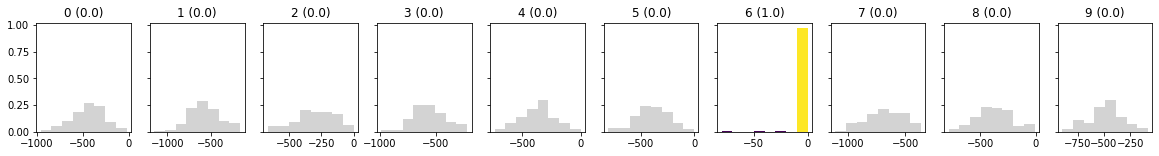

Correct


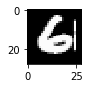

Real:  5


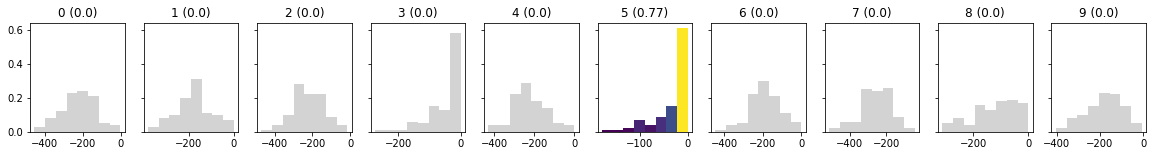

Correct


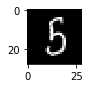

Real:  1


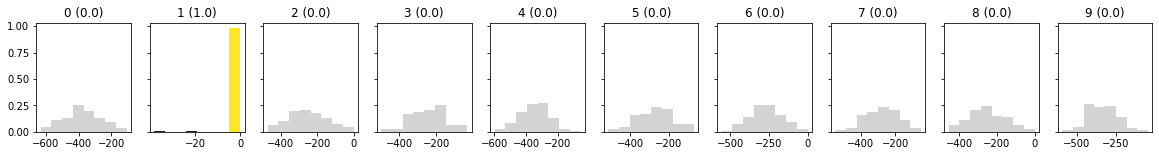

Correct


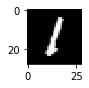

Real:  1


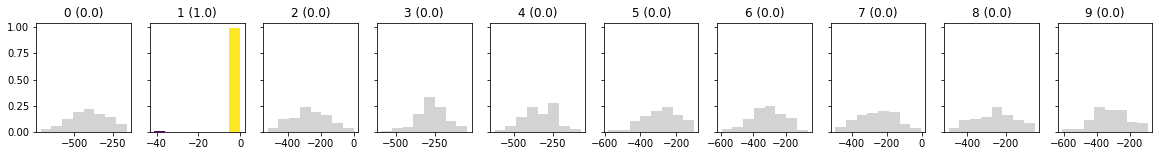

Correct


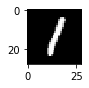

Real:  5


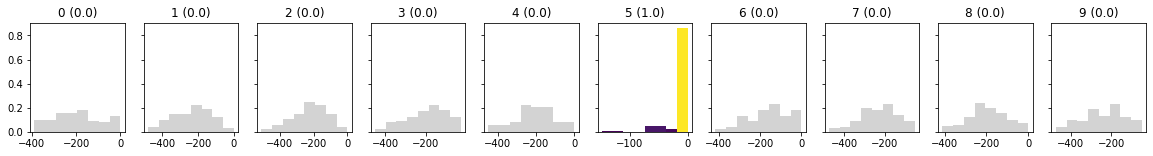

Correct


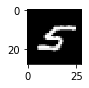

Real:  0


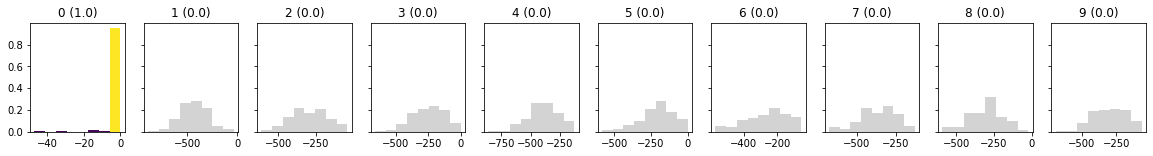

Correct


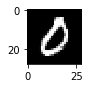

Real:  1


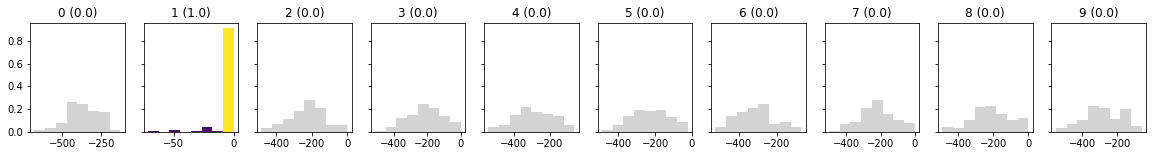

Correct


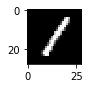

Real:  8


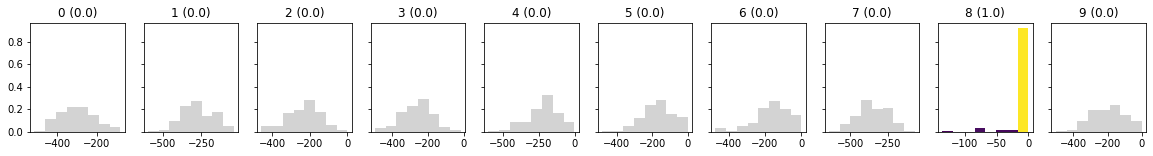

Correct


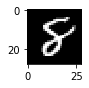

Real:  3


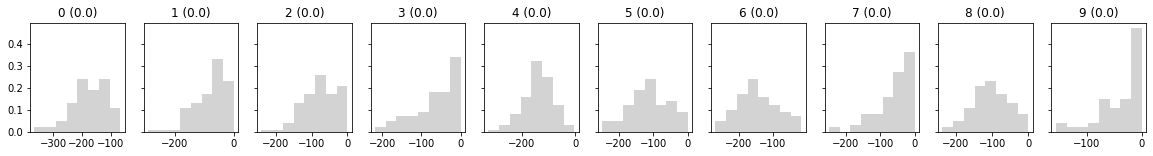

Undecided.


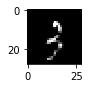

Real:  2


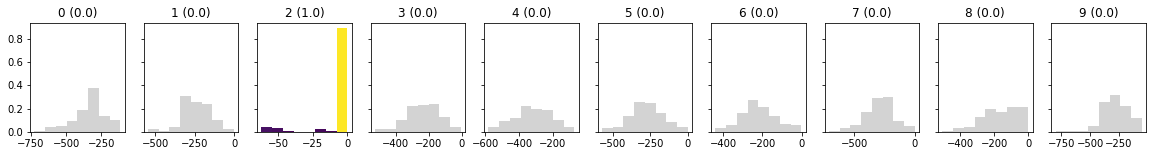

Correct


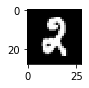

Real:  0


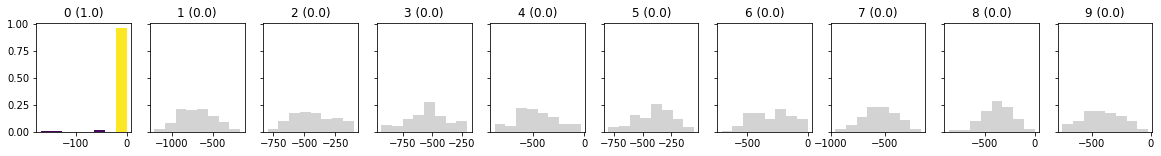

Correct


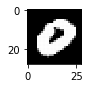

Real:  5


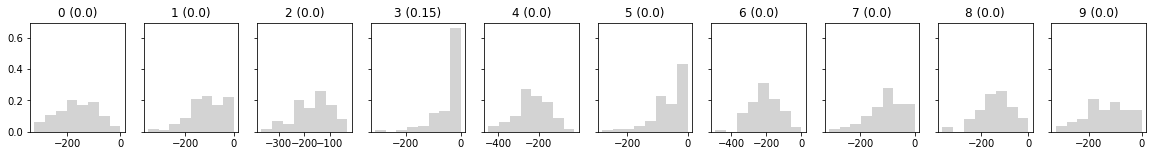

Undecided.


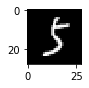

Real:  4


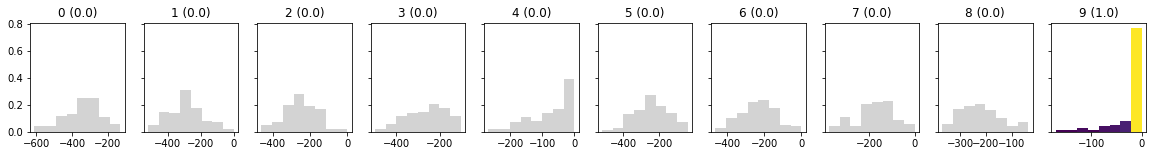

Incorrect :()


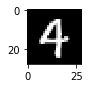

Real:  4


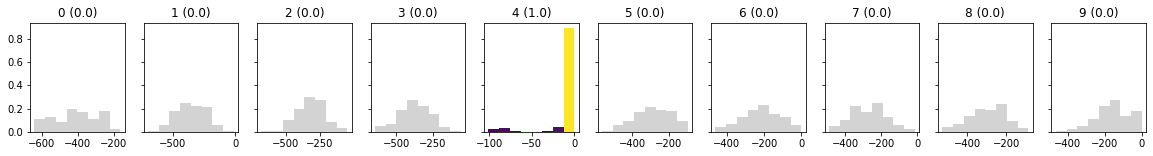

Correct


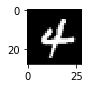

Real:  3


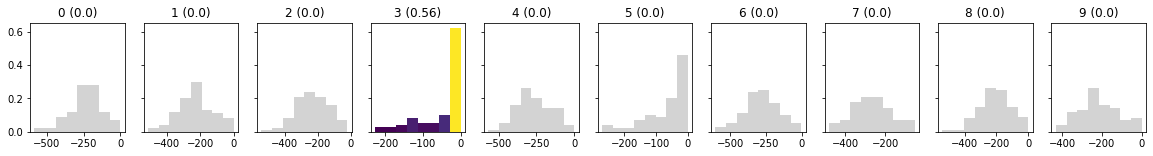

Correct


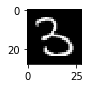

Real:  3


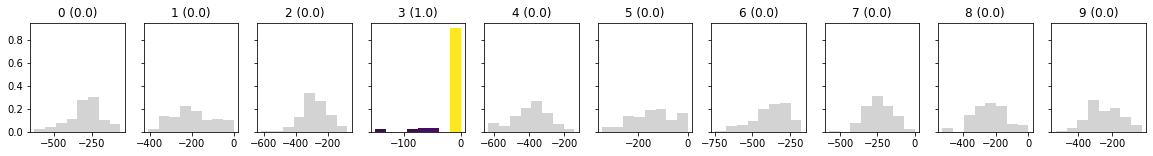

Correct


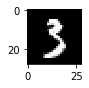

Real:  1


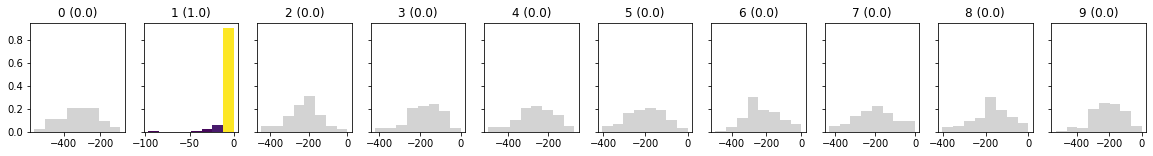

Correct


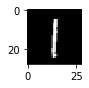

Real:  7


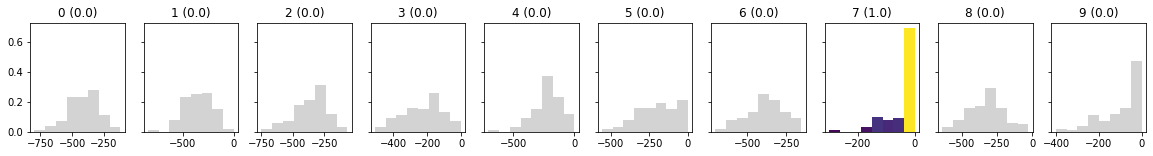

Correct


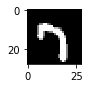

Real:  7


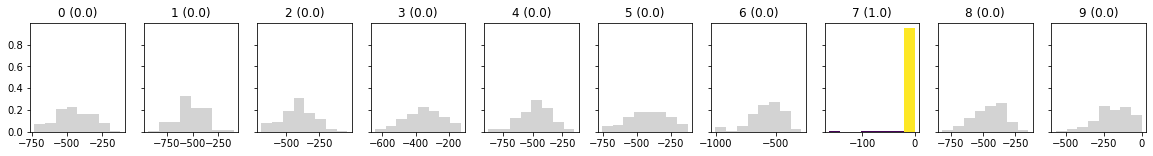

Correct


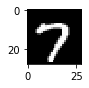

Real:  1


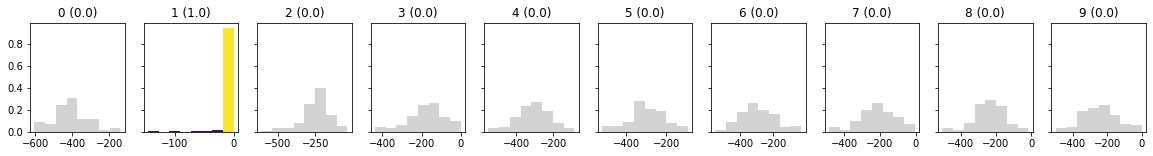

Correct


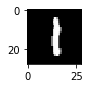

Real:  2


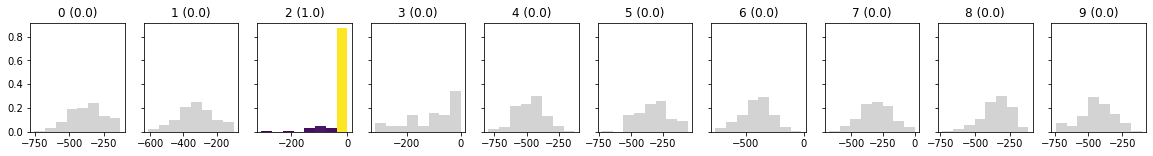

Correct


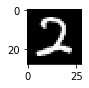

Real:  8


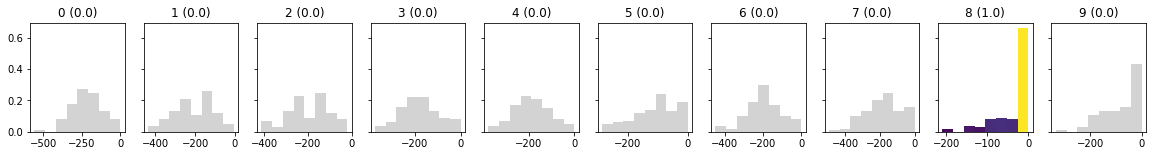

Correct


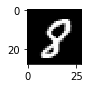

Real:  5


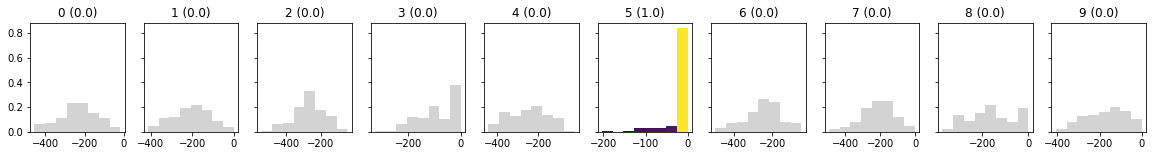

Correct


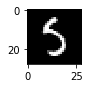

Real:  1


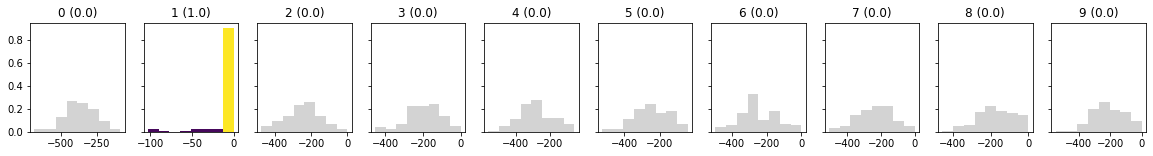

Correct


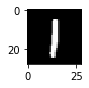

Real:  7


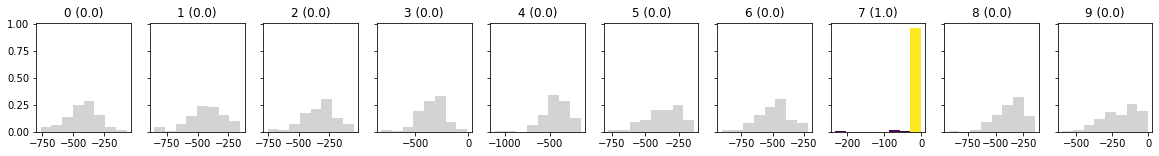

Correct


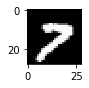

Real:  8


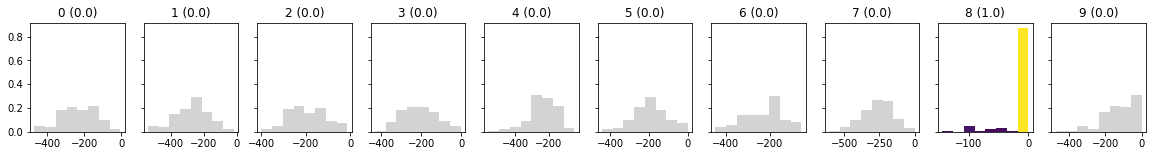

Correct


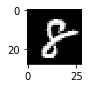

Real:  4


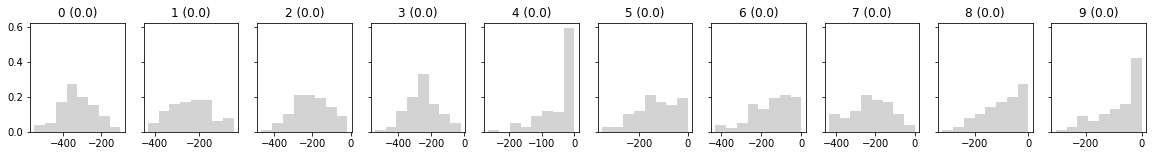

Undecided.


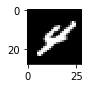

Real:  6


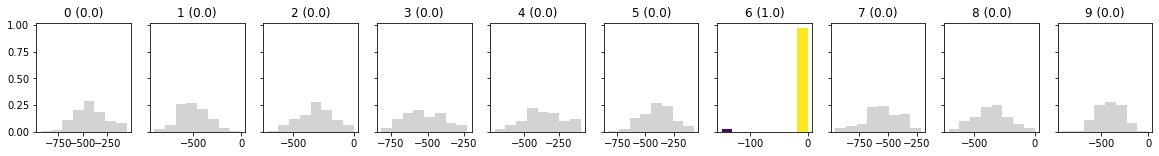

Correct


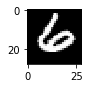

Real:  2


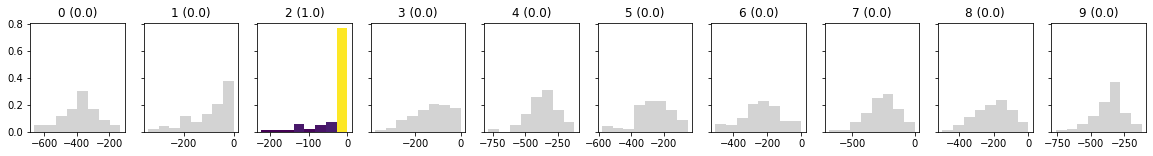

Correct


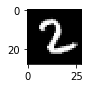

Real:  4


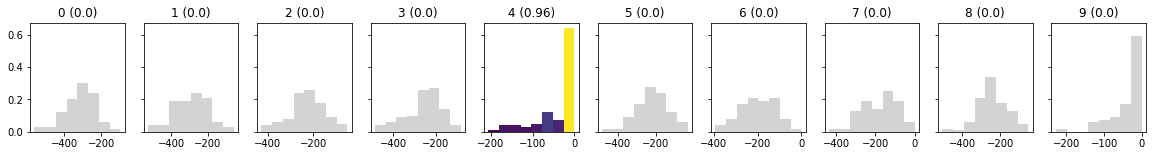

Correct


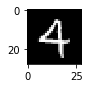

Real:  0


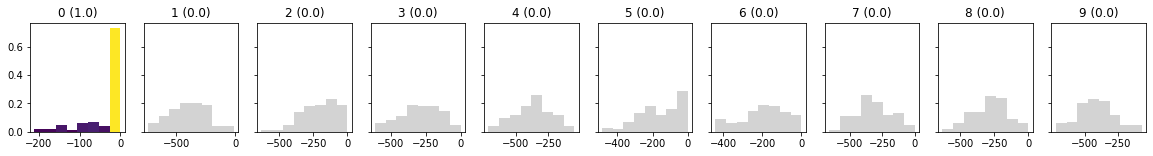

Correct


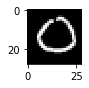

Real:  8


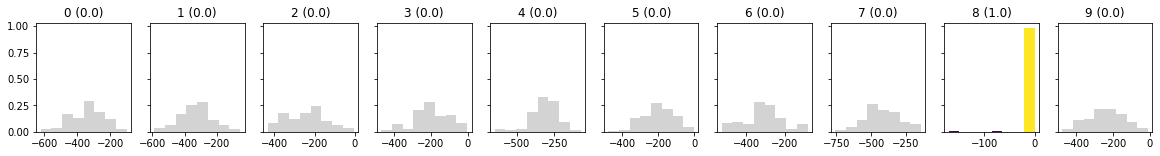

Correct


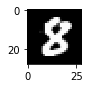

Real:  4


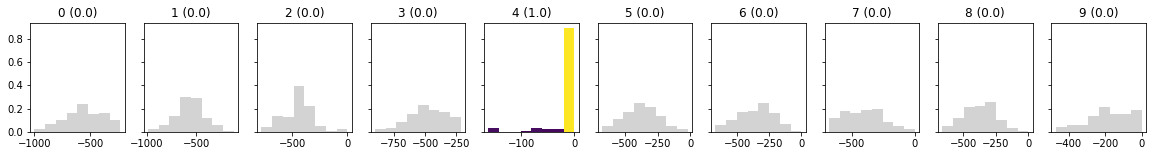

Correct


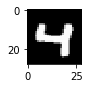

Real:  7


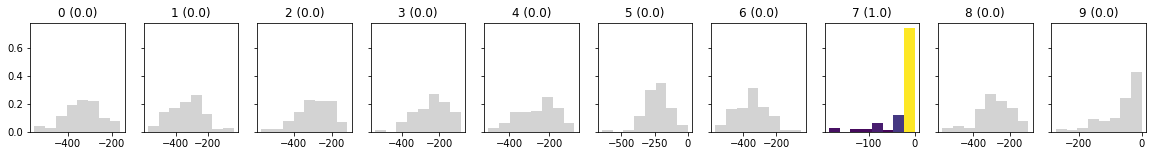

Correct


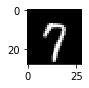

Real:  4


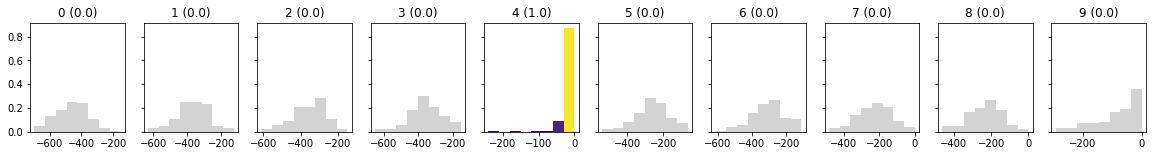

Correct


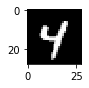

Real:  2


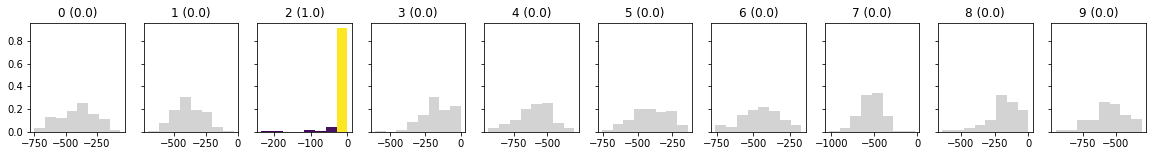

Correct


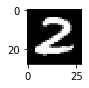

Real:  1


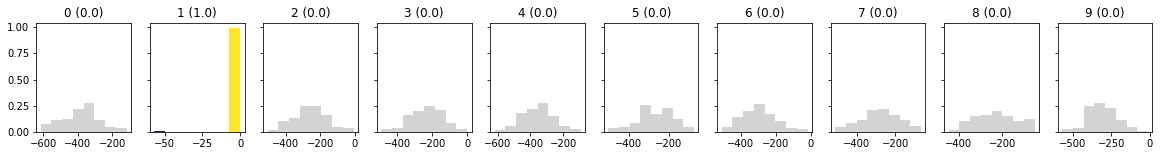

Correct


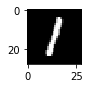

Real:  2


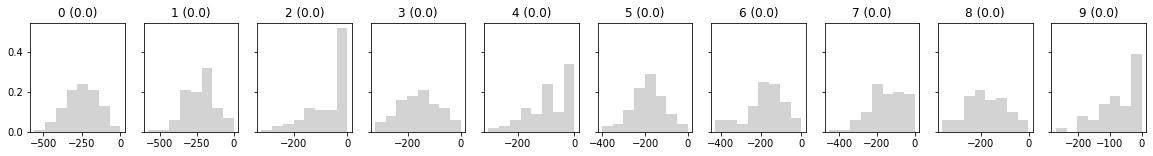

Undecided.


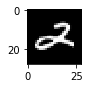

Real:  1


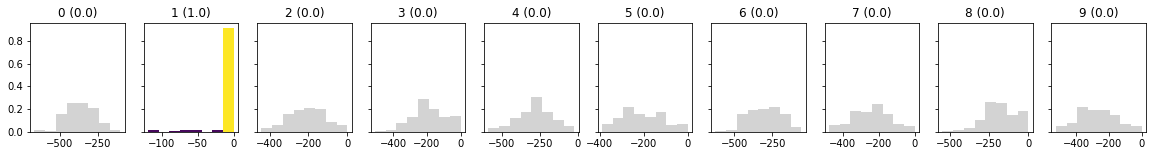

Correct


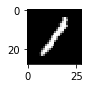

Real:  9


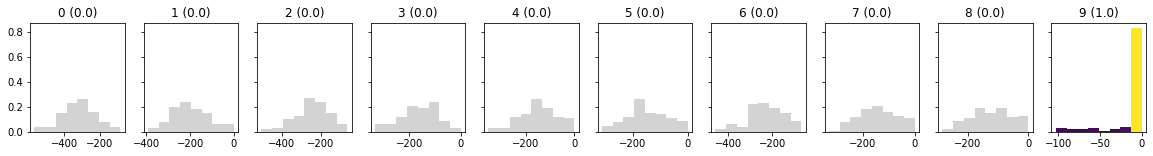

Correct


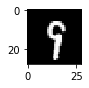

Real:  5


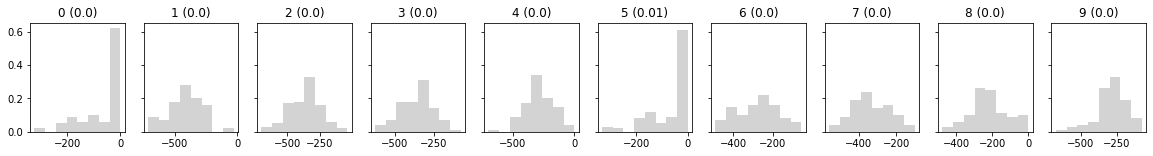

Undecided.


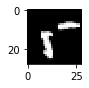

Real:  4


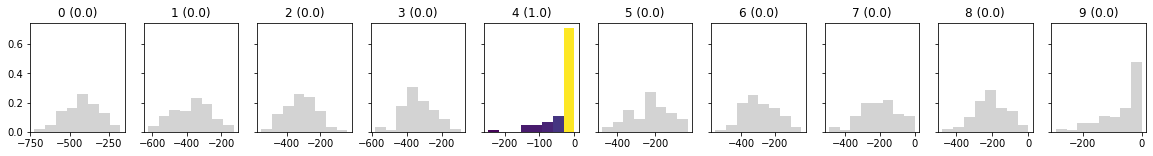

Correct


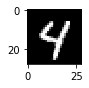

Real:  3


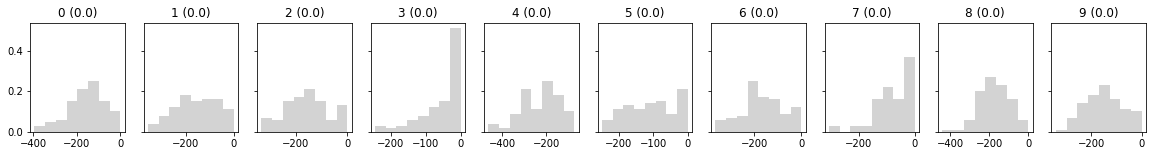

Undecided.


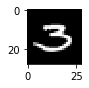

Real:  3


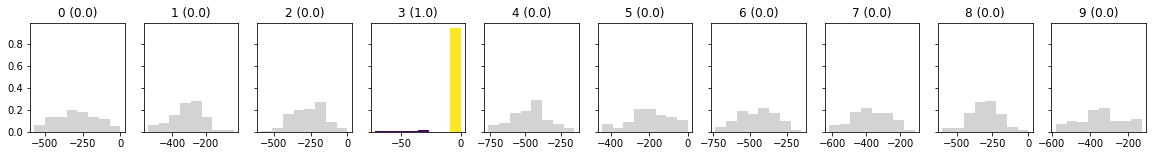

Correct


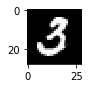

Real:  0


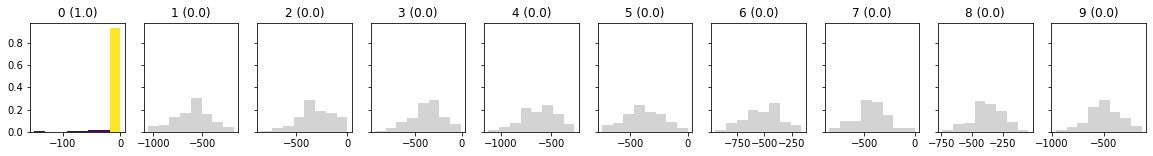

Correct


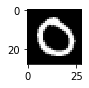

Real:  2


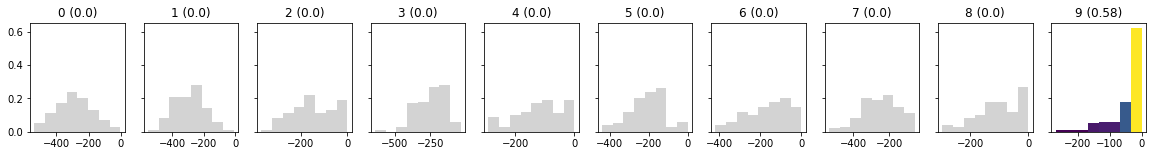

Incorrect :()


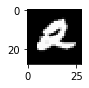

Real:  6


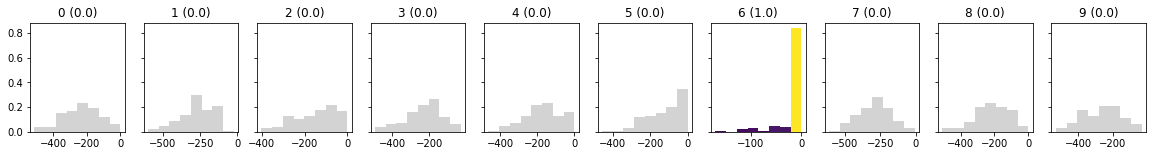

Correct


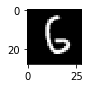

Real:  1


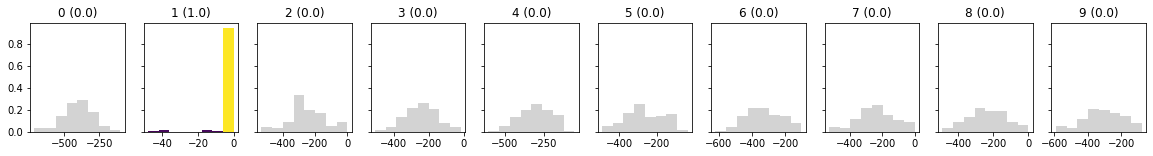

Correct


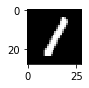

Real:  2


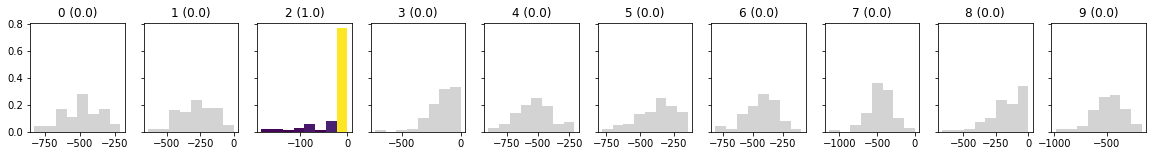

Correct


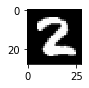

Real:  7


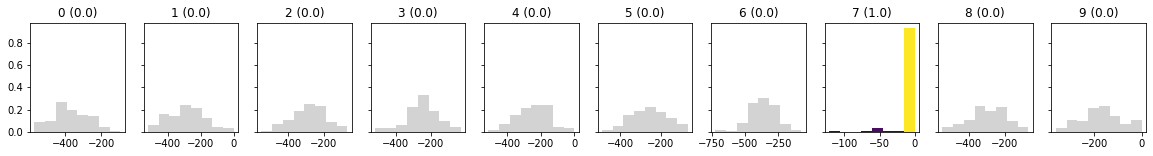

Correct


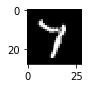

Real:  7


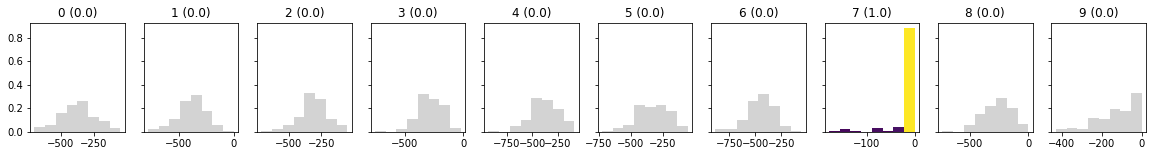

Correct


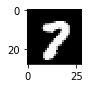

Real:  2


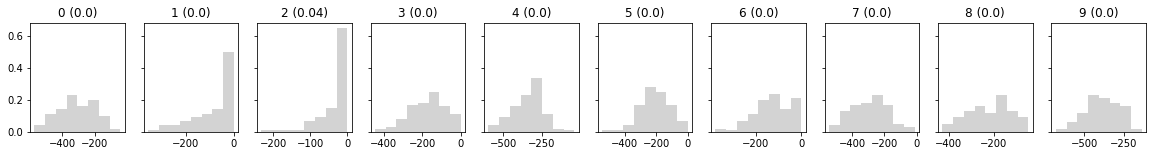

Undecided.


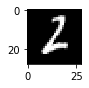

Real:  1


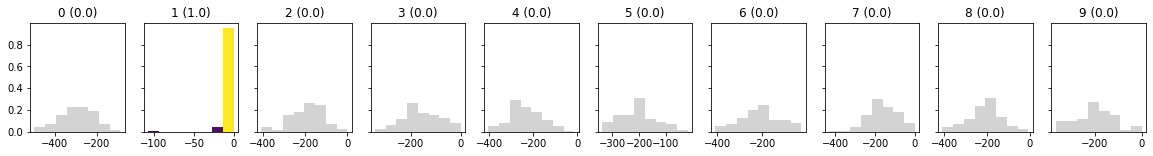

Correct


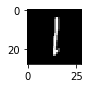

Real:  3


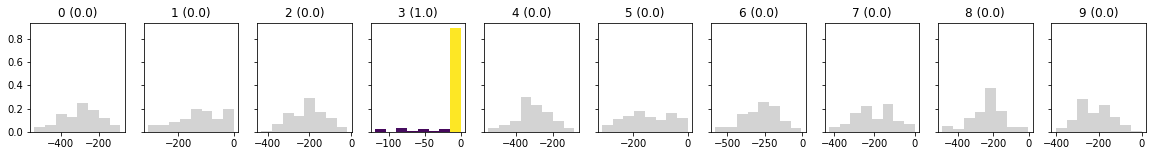

Correct


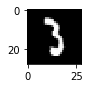

Real:  3


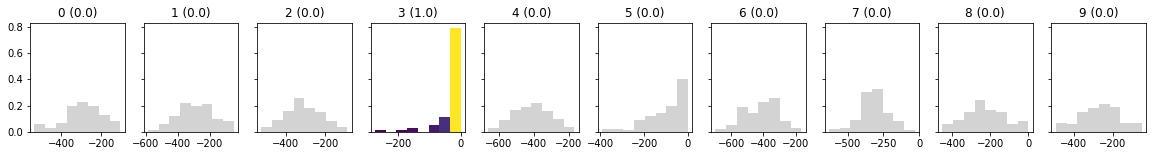

Correct


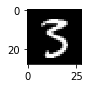

Real:  1


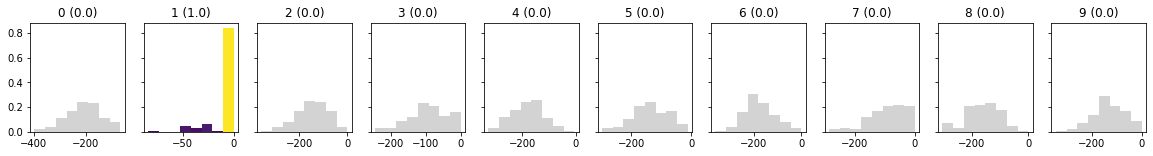

Correct


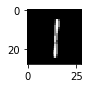

Real:  5


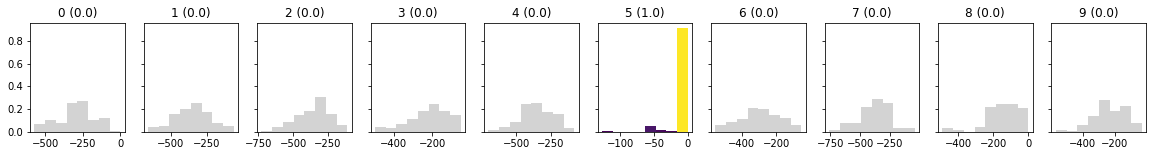

Correct


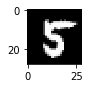

Real:  2


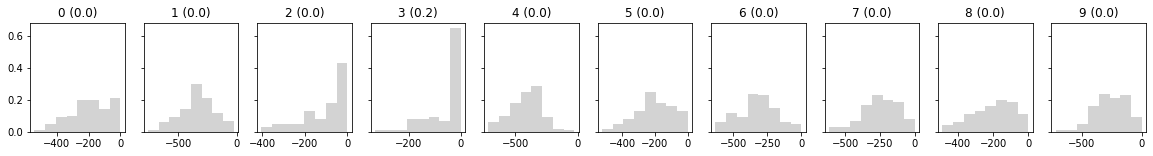

Undecided.


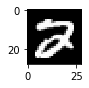

Real:  8


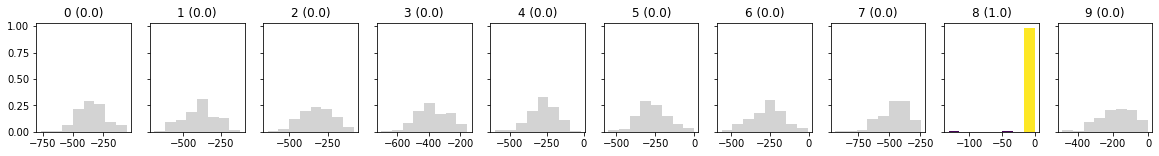

Correct


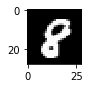

Real:  7


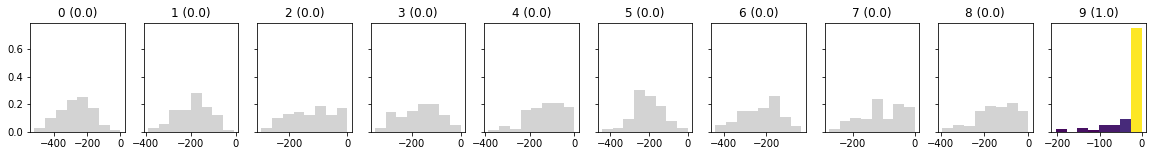

Incorrect :()


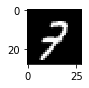

Real:  3


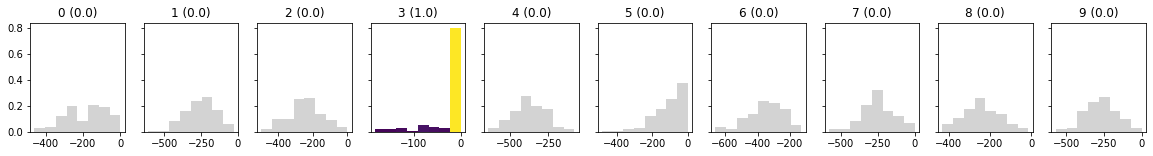

Correct


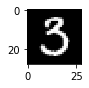

Real:  5


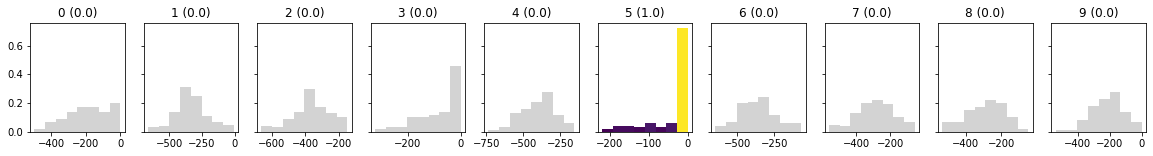

Correct


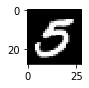

Real:  8


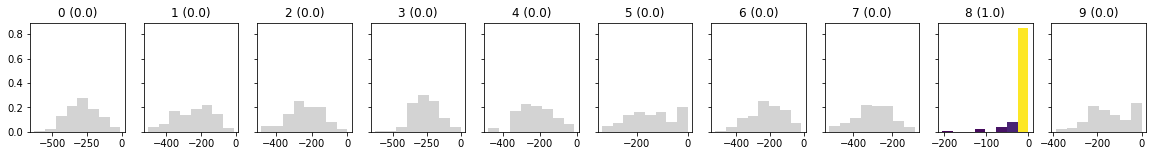

Correct


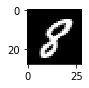

Real:  7


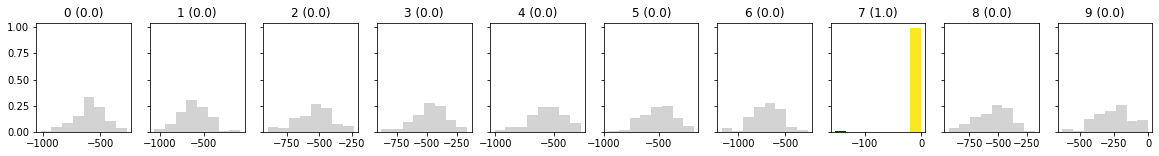

Correct


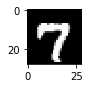

Real:  8


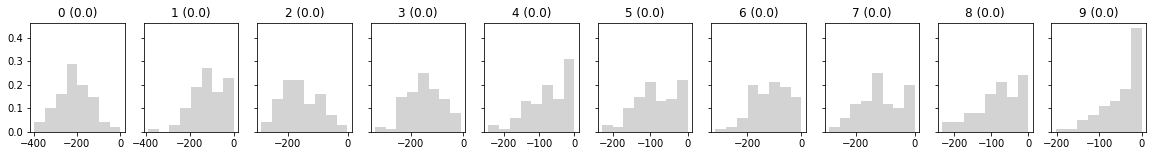

Undecided.


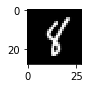

Real:  2


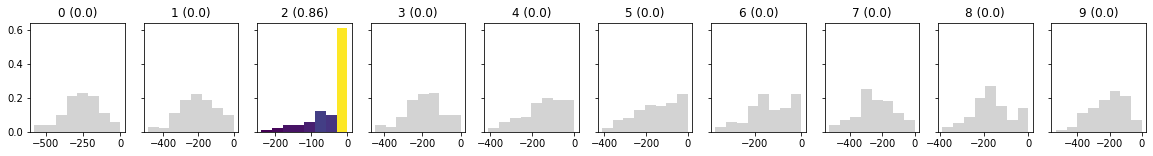

Correct


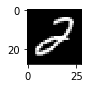

Real:  6


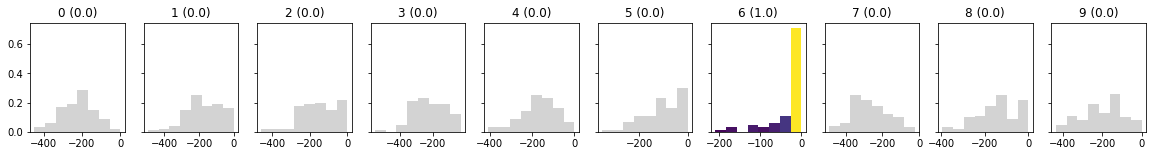

Correct


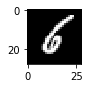

Real:  5


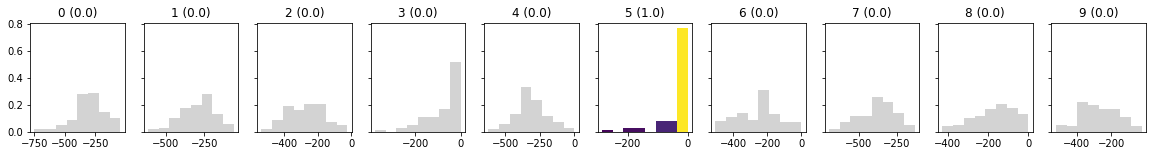

Correct


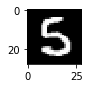

Real:  5


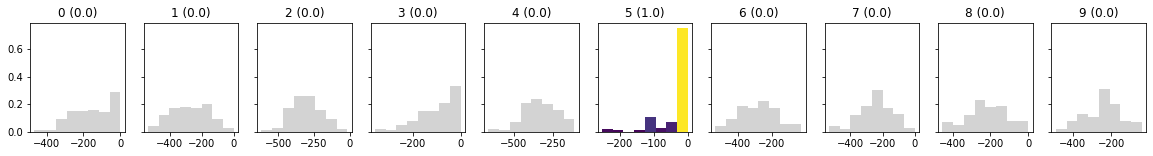

Correct


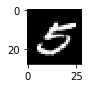

Real:  8


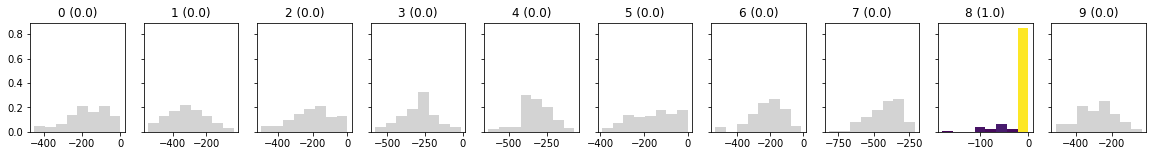

Correct


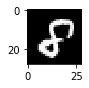

Real:  9


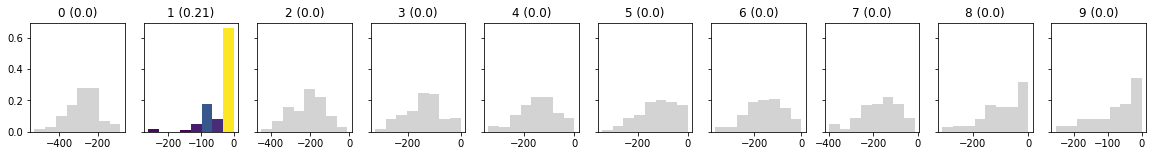

Incorrect :()


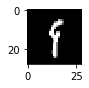

Real:  5


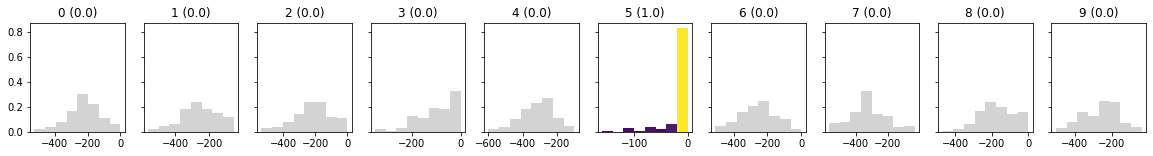

Correct


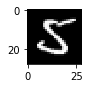

Real:  7


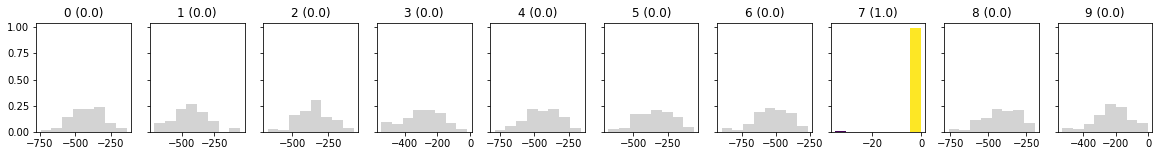

Correct


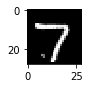

Real:  7


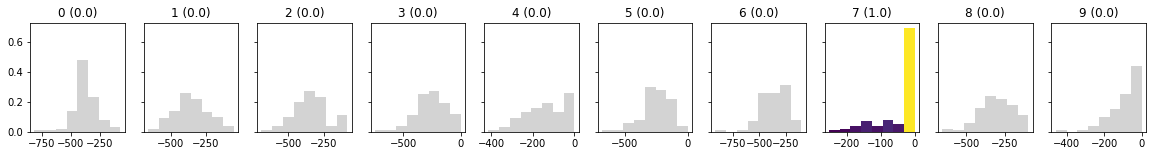

Correct


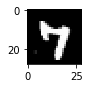

Real:  4


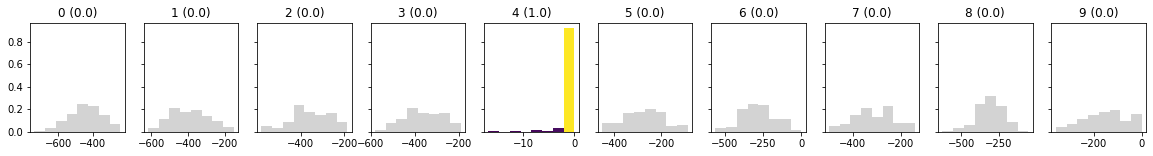

Correct


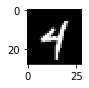

Real:  3


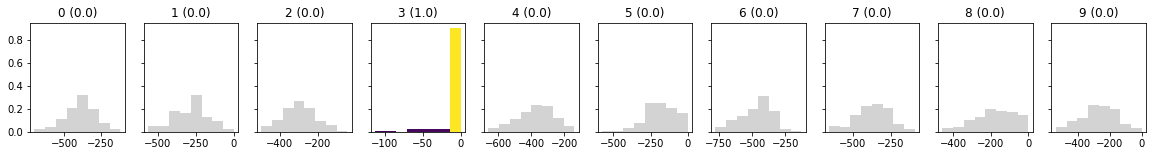

Correct


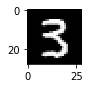

Real:  6


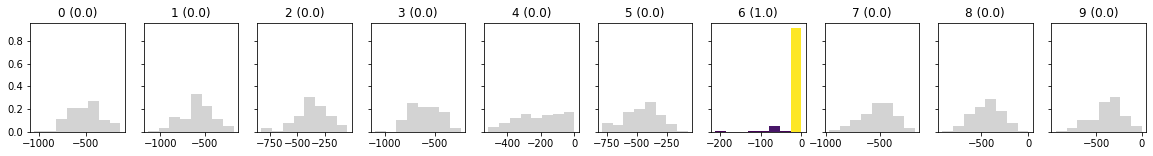

Correct


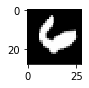

Real:  4


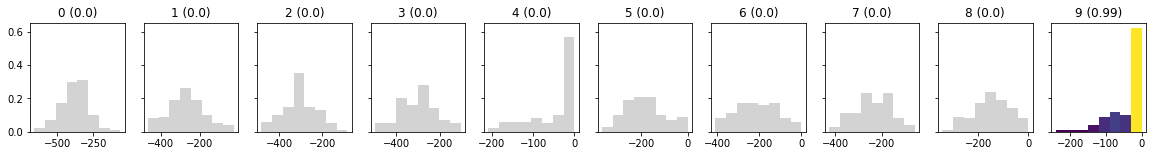

Incorrect :()


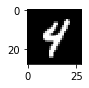

Real:  8


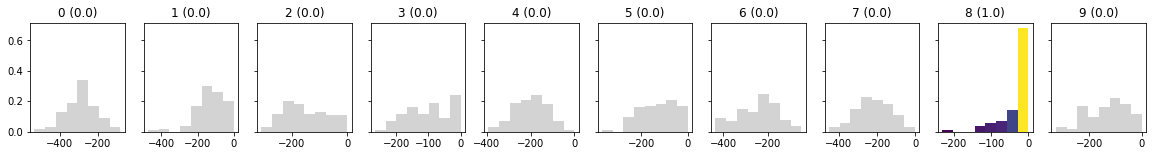

Correct


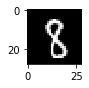

Real:  2


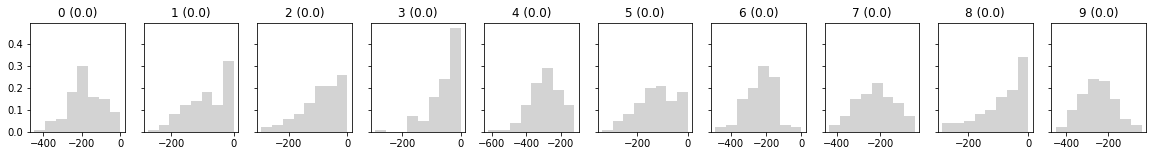

Undecided.


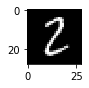

Real:  3


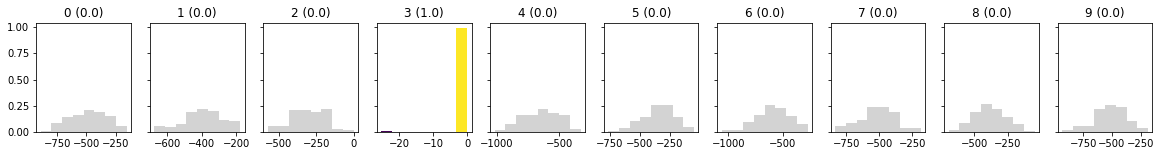

Correct


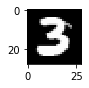

Real:  8


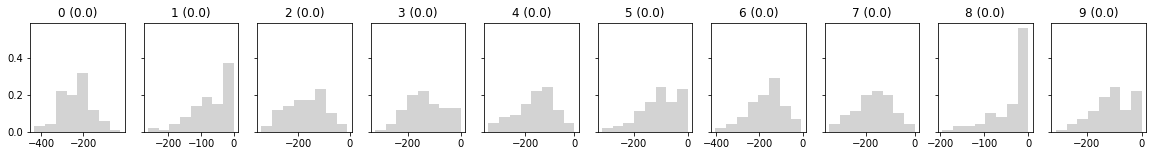

Undecided.


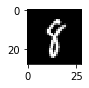

Real:  9


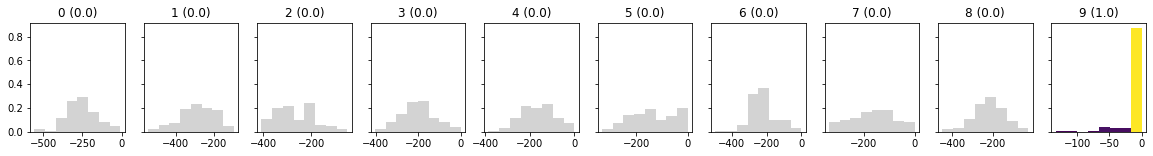

Correct


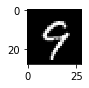

Real:  7


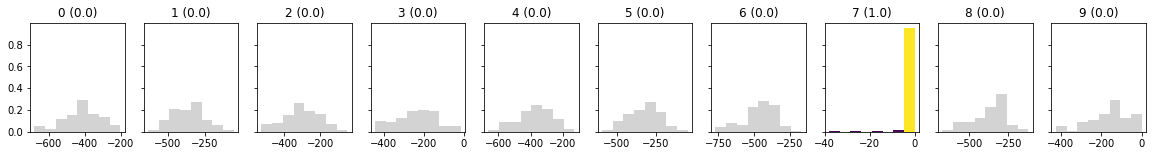

Correct


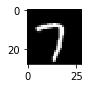

Real:  7


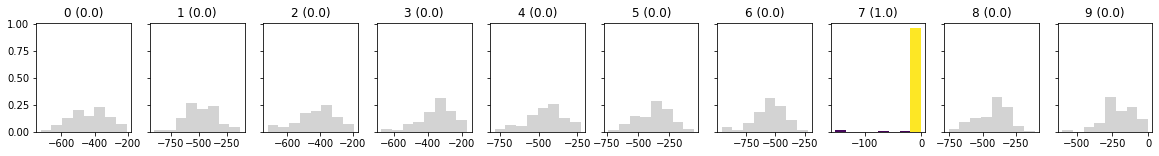

Correct


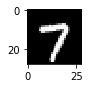

Real:  6


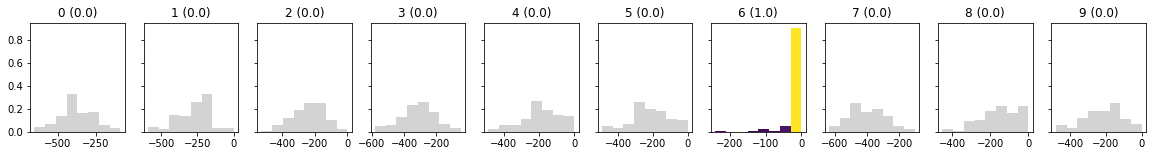

Correct


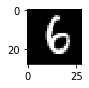

Summary
Total images:  128
Predicted for:  111
Accuracy when predicted:  0.9369369369369369
Total images:  128
Skipped:  17
Accuracy when made predictions: 93 %


In [24]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=True)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch
    break

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

# An other way to print uncertainty

In [0]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.Resize(28,28),transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

In [0]:
def variance(yhats,mean): #tensor 100,128,10, tensor 128,10
  means = np.argmax(mean,axis = 1) #128 toutes nos preds moyennes
  toutes_preds = np.argmax(yhats,axis = 2) #tensor 100,128
  vals = [[(toutes_preds[i,j]== means[j]).item() for i in range(toutes_preds.shape[0])] for j in range(toutes_preds.shape[1])]  
  percent = [np.mean(vals[i]) for i in range(toutes_preds.shape[1])] #128
  var = [np.mean([((toutes_preds[i,j]==means[j]).item() - percent[j])**2 for i in range(toutes_preds.shape[0])]) for j in range(toutes_preds.shape[1])]
  return percent,means,var


In [0]:
num_samples = 100
def predict2(x,num_samples): #pour une image
    sampled_models = [guide(None, None) for _ in range(num_samples)]  
    yhats = [model(x).data for model in sampled_models] #Pour chacun de ces models
    mean = torch.mean(torch.stack(yhats), 0) #on calcul la moyenne de ses yhats
    percent,means,var = variance(torch.stack(yhats),mean)
    return percent,means,var,torch.stack(yhats)

In [28]:
correct = 0
total = 0
values = [] #value to input of the claasifier
labels_v = [] #label 0 or 1
labelss = [] #the class of the image
stacks = [] #all the output of the 100 NN for each images
for j, data in tqdm(enumerate(test_loader)):
    images, labels = data
    percent,means,var,stack = predict2(images.view(-1,28*28),100)
    for i in range(len(means)):
      values.append((percent[i],means[i],var[i]))
      labelss.append(labels[i].item())
      stacks.append(stack[:,i,:])
      if means[i] != labels[i].item():
        #print("false")
        #print(percent[i],means[i],labels[i],var[i])
        labels_v.append(0) #false
      else:
        #print("correct")
        #print(percent[i],means[i],labels[i],var[i])
        correct = correct +1
        labels_v.append(1)
      total = total + 1
print("ratio: ",correct/total)
  

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
79it [07:58,  5.84s/it]

ratio:  0.9014


In [0]:
X = values[:int(len(values)/2)]
Y = labels_v[:int(len(values)/2)]
labels_train = labelss[:int(len(labelss)/2)]
stacks_train = stacks[:int(len(stacks)/2)]
X_test = values[int(len(values)/2):]
Y_test = labels_v[int(len(values)/2):]
labels_test = labelss[int(len(labelss)/2):]
stacks_test = stacks[int(len(stacks)/2):]

#Prediction on the test set if we use only the mean of our BNN, without looking the uncertainty

In [30]:
count = 0
for i in range(len(X_test)):
  if X_test[i][1].item() == labels_test[i]:
    count = count +1
print("Accuracy :", count / len(X_test))


Accuracy : 0.9022


In [31]:
print("Nombre de réponses:",len(X_test))
print("Nombre de réponses bonnes:", count)

Nombre de réponses: 5000
Nombre de réponses bonnes: 4511


# Train a classifier to decide if we want to predict a value or not

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression()
reg.fit(X, Y)
reg.score(X_test,Y_test)

0.9128

In [0]:
pred = reg.predict(X_test)

In [0]:
count = 0
n_answer = 0
n_unanswer = 0
n_unanswer_false = 0
n_answer_false = 0
n_answer_true = 0
n_unanswer_true = 0
for i in range(len(X_test)):
  if pred[i] == 1:
    n_answer = n_answer + 1
    if X_test[i][1].item() == labels_test[i]:
      n_answer_true = n_answer_true +1
    else:
      n_answer_false = n_answer_false +1
  else:
    n_unanswer = n_unanswer + 1
    if X_test[i][1].item() == labels_test[i]:
      n_unanswer_false = n_unanswer_false +1
    else:
      n_unanswer_true = n_unanswer_true +1
    

In [35]:
print("nombre de réponses: ",n_answer)
print("nombre de bonnes réponses: ",n_answer_true)
print("nombre de mauvaises réponses: ",n_answer_false)
print("Accuracy when decide to answer: ",n_answer_true/n_answer)

nombre de réponses:  4773
nombre de bonnes réponses:  4424
nombre de mauvaises réponses:  349
Accuracy when decide to answer:  0.9268803687408339


In [36]:
print("nombre de réponses évités: ",n_unanswer)
print("nombre de réponses évitées à raison: ",n_unanswer_true)
print("nombre de réponses évitées à tord: ",n_unanswer_false)
print("pourcentage de fois ou l'on a bien fait de ne pas répondre: ",n_unanswer_true/n_unanswer)

nombre de réponses évités:  227
nombre de réponses évitées à raison:  140
nombre de réponses évitées à tord:  87
pourcentage de fois ou l'on a bien fait de ne pas répondre:  0.6167400881057269


# Use a confidence interval to decide if we want to predict or not with OFUL

In [0]:
lower_bound_proba = 0.5

In [0]:
count = 0
n_answer = 0
n_unanswer = 0
n_unanswer_false = 0
n_answer_false = 0
n_answer_true = 0
n_unanswer_true = 0
for i in range(len(X_test)):
  percent,mean,var = X_test[i]
  if percent - (1.96 * var**0.5)/100 > lower_bound_proba:
    n_answer = n_answer + 1
    if X_test[i][1].item() == labels_test[i]:
      n_answer_true = n_answer_true +1
    else:
      n_answer_false = n_answer_false +1
  else:
    n_unanswer = n_unanswer + 1
    if X_test[i][1].item() == labels_test[i]:
      n_unanswer_false = n_unanswer_false +1
    else:
      n_unanswer_true = n_unanswer_true +1
    

In [39]:
print("nombre de réponses: ",n_answer)
print("nombre de bonnes réponses: ",n_answer_true)
print("nombre de mauvaises réponses: ",n_answer_false)
print("Accuracy when decide to answer: ",n_answer_true/n_answer)

nombre de réponses:  4319
nombre de bonnes réponses:  4139
nombre de mauvaises réponses:  180
Accuracy when decide to answer:  0.9583236860384349


In [40]:
print("nombre de réponses évités: ",n_unanswer)
print("nombre de réponses évitées à raison: ",n_unanswer_true)
print("nombre de réponses évitées à tord: ",n_unanswer_false)
print("pourcentage de fois ou l'on a bien fait de ne pas répondre: ",n_unanswer_true/n_unanswer)

nombre de réponses évités:  681
nombre de réponses évitées à raison:  309
nombre de réponses évitées à tord:  372
pourcentage de fois ou l'on a bien fait de ne pas répondre:  0.45374449339207046


# Make a prediction with a monkey image wich is not in the MNIST DATASET

In [0]:
transf = transforms.Compose([
    
    
    transforms.Resize((28,28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485],
                                 std=[0.229])
])

In [0]:
loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('/content/image',
                         transform=transf),
    batch_size=1, shuffle=False, num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


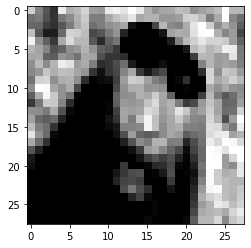

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(loader)
images, labels = dataiter.next()
image = images[0]
label = labels[0]

# show images
imshow(torchvision.utils.make_grid(image))

# Without taking into account uncertainty : False answer

In [44]:
correct = 0
total = 0
values = [] #value to input of the claasifier
labels_v = [] #label 0 or 1
labelss = [] #the class of the image
stacks = [] #all the output of the 100 NN for each images
for j, data in tqdm(enumerate(loader)):
    images, labels = data
    labels[0] = labels[0]+12
    percent,means,var,stack = predict2(images.view(-1,28*28),100)
    for i in range(len(means)):
      values.append((percent[i],means[i],var[i]))
      labelss.append(labels[i].item())
      stacks.append(stack[:,i,:])
      if means[i] != labels[i].item():
        print("false")
        print(percent[i],means[i],labels[i],var[i])
        labels_v.append(0) #false
      else:
        print("correct")
        print(percent[i],means[i],labels[i],var[i])
        correct = correct +1
        labels_v.append(1)
      total = total + 1
print("ratio: ",correct/total)
  

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
1it [00:06,  6.53s/it]

false
0.37 tensor(5) tensor(12) 0.23309999999999997
ratio:  0.0


# Taking uncertainty into account : Prefer not answer

In [0]:
pred = reg.predict(values)

In [0]:
count = 0
n_answer = 0
n_unanswer = 0
n_unanswer_false = 0
n_answer_false = 0
n_answer_true = 0
n_unanswer_true = 0
for i in range(len(values)):
  if pred[i] == 1:
    n_answer = n_answer + 1
    if values[i][1].item() == labels_test[i]:
      n_answer_true = n_answer_true +1
    else:
      n_answer_false = n_answer_false +1
  else:
    n_unanswer = n_unanswer + 1
    if values[i][1].item() == labels_test[i]:
      n_unanswer_false = n_unanswer_false +1
    else:
      n_unanswer_true = n_unanswer_true +1


In [47]:
print("nombre de réponses: ",n_answer)
print("nombre de bonnes réponses: ",n_answer_true)
print("nombre de mauvaises réponses: ",n_answer_false)

nombre de réponses:  1
nombre de bonnes réponses:  0
nombre de mauvaises réponses:  1


In [48]:
print("nombre de réponses évités: ",n_unanswer)
print("nombre de réponses évitées à raison: ",n_unanswer_true)
print("nombre de réponses évitées à tord: ",n_unanswer_false)

nombre de réponses évités:  0
nombre de réponses évitées à raison:  0
nombre de réponses évitées à tord:  0


# Plot the uncertainty for a MNIST image wrt the number of model generated 

In [0]:
num_samples = [i for i in range(101)]
def predict3(x,num_samples): #pour une image
    sampled_models = [guide(None, None) for _ in range(num_samples[-1])]  #on tire plusieurs variables 10 fois pour chaque layer
    yhats = [model(x).data for model in sampled_models] #Pour chacun de ces models
    liste = []
    for i in num_samples:
      y = torch.stack(yhats)[:i,:,:]
      mean = torch.mean(y, 0) #on calcul la moyenne de ses yhats
      percent,means,var = variance(y,mean)
      liste.append((percent,means,var))
    return liste

In [77]:
correct = 0
total = 0
values = {i:[] for i in num_samples}#[] #value to input of the claasifier
labels_v = {i:[] for i in num_samples} #[] #label 0 or 1
labelss ={i:[] for i in num_samples} #[] #the class of the image
for j, data in tqdm(enumerate(test_loader)):
    images, labels = data
    liste = predict3(images.view(-1,28*28),num_samples)
    for n in range(len(num_samples)) :
      percent,means,var = liste[n]
      tmp_values = []
      tmp_labels_v = []
      tmp_labelss = []
      for i in range(len(means)):
        tmp_values.append((percent[i],means[i],var[i]))
        tmp_labelss.append(labels[i].item())
        if means[i] != labels[i].item():
          tmp_labels_v.append(0) #false
        else:
          correct = correct +1
          tmp_labels_v.append(1)
        total = total + 1
      values[num_samples[n]].append(tmp_values)
      labels_v[num_samples[n]].append(tmp_labels_v)
      labelss[num_samples[n]].append(tmp_labelss)
      
    break


  



0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
idx= 0
for i in range(len(labels_v[10][0])):
  if labels_v[2][0][i] == 0 and values[100][0][i][2]<0.15 :
    idx = i
    break

In [0]:
lab_time = [] #la réponse true ou false en fonction du temps
true_lab = [] # la classe
time_percent = [] #percent,mean,var en fonction du temps
time_mean = []
time_var = []
for i in num_samples: 
  lab_time.append(labels_v[i][0][idx])
  true_lab.append(labelss[i][0][idx])
  percent,mean,var = values[i][0][idx]
  time_mean.append(mean)
  time_percent.append(percent)
  time_var.append(var)


In [0]:
import matplotlib.pyplot as plt

In [0]:
good_pred = (np.array(time_mean) == true_lab)[:100]
false_idx = []
true_idx = []
for i in range(good_pred.shape[0]):
  if good_pred[i] == False:
    false_idx.append(i)
  else:
    true_idx.append(i)

false_idx.append(false_idx[-1]+1)

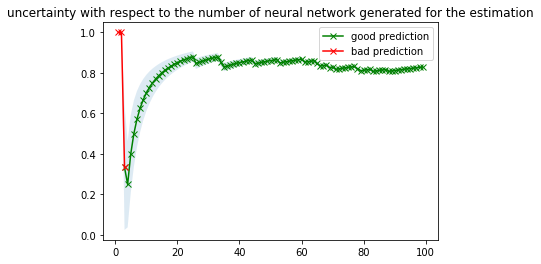

In [85]:
plt.plot(np.array(num_samples)[true_idx],np.array(time_percent)[true_idx],'H-',marker = "x",color = "green",label = "good prediction")
plt.plot(np.array(num_samples)[false_idx],np.array(time_percent)[false_idx],'H-',marker = "x",color = "red",label = "bad prediction")
plt.fill_between(np.array(num_samples[1:100]), np.array(time_percent[1:100]) - (1.96*np.array(time_var[1:100])**0.5)/np.array(num_samples[1:100]),np.array(time_percent[1:100]) + (1.96*np.array(time_var[1:100])**0.5)/np.array(num_samples[1:100]), alpha=0.15)
plt.title("uncertainty with respect to the number of neural network generated for the estimation")
plt.legend()

# We take uncertainty into account uncertainty for the monkey image

In [60]:
correct = 0
total = 0
values = {i:[] for i in num_samples}#[] #value to input of the claasifier
labels_v = {i:[] for i in num_samples} #[] #label 0 or 1
labelss ={i:[] for i in num_samples} #[] #the class of the image
for j, data in tqdm(enumerate(loader)):
    images, labels = data
    labels = labels + 12
    liste = predict3(images.view(-1,28*28),num_samples)
    for n in range(len(num_samples)) :
      percent,means,var = liste[n]
      tmp_values = []
      tmp_labels_v = []
      tmp_labelss = []
      for i in range(len(means)):
        tmp_values.append((percent[i],means[i],var[i]))
        tmp_labelss.append(labels[i].item())
        if means[i] != labels[i].item():
          tmp_labels_v.append(0) #false
        else:
          correct = correct +1
          tmp_labels_v.append(1)
        total = total + 1
      values[num_samples[n]].append(tmp_values)
      labels_v[num_samples[n]].append(tmp_labels_v)
      labelss[num_samples[n]].append(tmp_labelss)
      
    break




0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:406: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
idx = 0

In [0]:
lab_time = [] #la réponse true ou false en fonction du temps liste de taille 500
true_lab = [] # la classe
time_percent = [] #percent,mean,var en fonction du temps
time_mean = []
time_var = []
for i in num_samples: 
  lab_time.append(labels_v[i][0][idx])
  true_lab.append(labelss[i][0][idx])
  percent,mean,var = values[i][0][idx]
  time_mean.append(mean)
  time_percent.append(percent)
  time_var.append(var)

In [0]:
x = []
label = []
for i in num_samples[1:]:
  x.append((time_percent[i],time_mean[i],time_var[i]))
  label.append(lab_time[i])

In [0]:
pred = [0]+list(reg.predict(x))

In [0]:
good_pred = (np.array(time_mean) == true_lab)[:100]
false_idx = []
true_idx = []
no_idx = []
for i in range(good_pred.shape[0]):
  if pred[i] == 1:
    no_idx.append(i)
  elif good_pred[i] == False:
    false_idx.append(i)
  else:
    true_idx.append(i)

false_idx.append(false_idx[-1]+1)

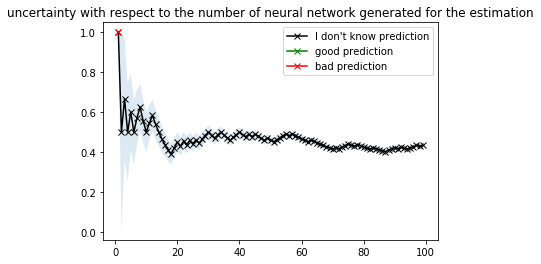

In [66]:
plt.plot(np.array(num_samples)[no_idx],np.array(time_percent)[no_idx],'H-',marker = "x",color = "black",label = "I don't know prediction")
plt.plot(np.array(num_samples)[true_idx],np.array(time_percent)[true_idx],'H-',marker = "x",color = "green",label = "good prediction")
plt.plot(np.array(num_samples)[false_idx],np.array(time_percent)[false_idx],'H-',marker = "x",color = "red",label = "bad prediction")
plt.fill_between(np.array(num_samples[1:100]), np.array(time_percent[1:100]) - (1.96*np.array(time_var[1:100])**0.5)/np.array(num_samples[1:100]),np.array(time_percent[1:100]) + (1.96*np.array(time_var[1:100])**0.5)/np.array(num_samples[1:100]), alpha=0.15)
plt.title("uncertainty with respect to the number of neural network generated for the estimation")
plt.legend()
  


# Same image but we don't take into account uncertainty

In [0]:
good_pred = (np.array(time_mean) == true_lab)[:100]
false_idx = []
true_idx = []
no_idx = []
for i in range(good_pred.shape[0]):
  if good_pred[i] == False:
    false_idx.append(i)
  else:
    true_idx.append(i)

false_idx.append(false_idx[-1]+1)

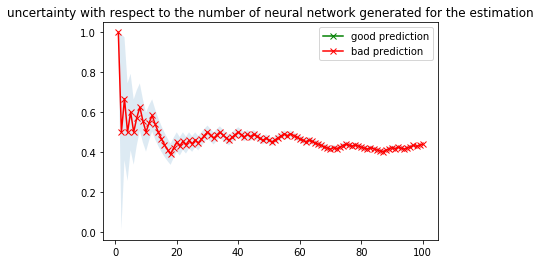

In [68]:
plt.plot(np.array(num_samples)[true_idx],np.array(time_percent)[true_idx],'H-',marker = "x",color = "green",label = "good prediction")
plt.plot(np.array(num_samples)[false_idx],np.array(time_percent)[false_idx],'H-',marker = "x",color = "red",label = "bad prediction")
plt.fill_between(np.array(num_samples[1:100]), np.array(time_percent[1:100]) - (1.96*np.array(time_var[1:100])**0.5)/np.array(num_samples[1:100]),np.array(time_percent[1:100]) + (1.96*np.array(time_var[1:100])**0.5)/np.array(num_samples[1:100]), alpha=0.15)
plt.title("uncertainty with respect to the number of neural network generated for the estimation")
plt.legend()